## Compare the triangulation obtained with Pose2Sim for various camera combinations

By: Léa Drolet-Roy

Last modification: 2025-08-15

In [1]:
import numpy as np
import json
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle

import seaborn as sns
import pandas as pd
from collections import defaultdict

from compare_keypoints_3D import draw_skeleton

from data_analysis import extract_coordinates, load_2d_keypoints, project_points_to_camera, get_MPJPE_per_cam, get_MPJPE_per_cam_CoM, plot_MPJPE_per_cam, plot_MPJPE_all_cams, get_all_error_stats

In [2]:
K = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0425/Intrinsics_K_conf.npz')['arr_0']
D = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0425/Intrinsics_D_conf.npz')['arr_0']
extrinsics = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/Extrinsics_optimized_20250429_12h00.npz')['arr_0']
world_T_cam = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/WorldTCam_opt.npz')['arr_0']

projMat = [np.linalg.inv(mat) for mat in world_T_cam]

In [3]:
pose2sim = ['Hip', 'RHip', 'RKnee', 'RAnkle', 'RBigToe', 'RSmallToe', 'RHeel', 'LHip', 'LKnee', 'LAnkle', 'LBigToe', 'LSmallToe', 'LHeel',
            'Neck', 'Nose', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
humans = ['Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist',
          'Hip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'Rear', 'LEar']

vit = ['Nose', 'REye', 'LEye', 'REar', 'LEar', 'RShoulder', 'LShoulder', 'RElbow', 'LElbow', 'RWrist', 'LWrist',
       'RHip', 'LHip', 'RKnee', 'LKnee', 'RAnkle', 'LAnkle']
pose2sim_vit = ['RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'Nose',
                'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']

# Match Pose2Sim keypoints with 4DHumans
common_indices_humans = [j for j in humans if j in pose2sim]
matching_pose2sim = [pose2sim.index(j) for j in common_indices_humans]
matching_humans = [humans.index(j) for j in common_indices_humans]

common_indices_vit = [j for j in vit if j in pose2sim_vit]
matching_pose2sim_vit = [pose2sim_vit.index(j) for j in common_indices_vit]
matching_vit = [vit.index(j) for j in common_indices_vit]

# define Rotation for Pose2Sim to World
R = np.array([[0, 0, 1],
              [-1, 0, 0],
              [0, 1, 0]])

### Graph reprojection error according to number of cameras used

In [5]:
with open('/home/lea/trampo/Pose2Sim/pose-3d-vit-multi/vit_reprojection_errors_cam_combi.json', 'r') as f:
    errors_seq_cam = json.load(f)

Mean error: 4.10 px


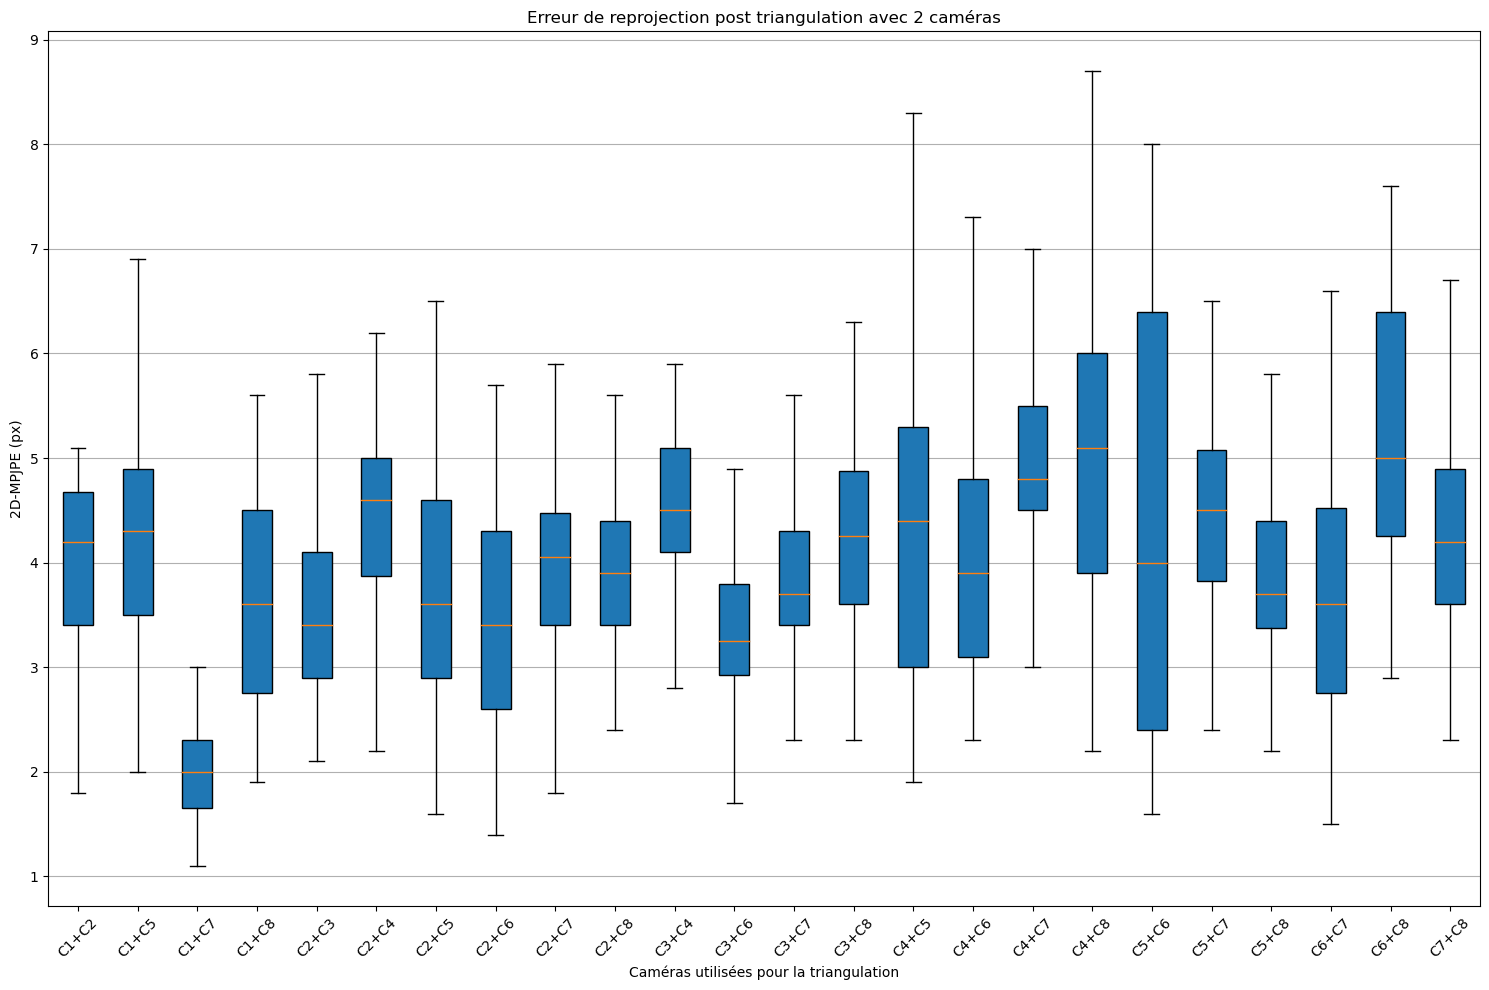

Mean error: 5.88 px


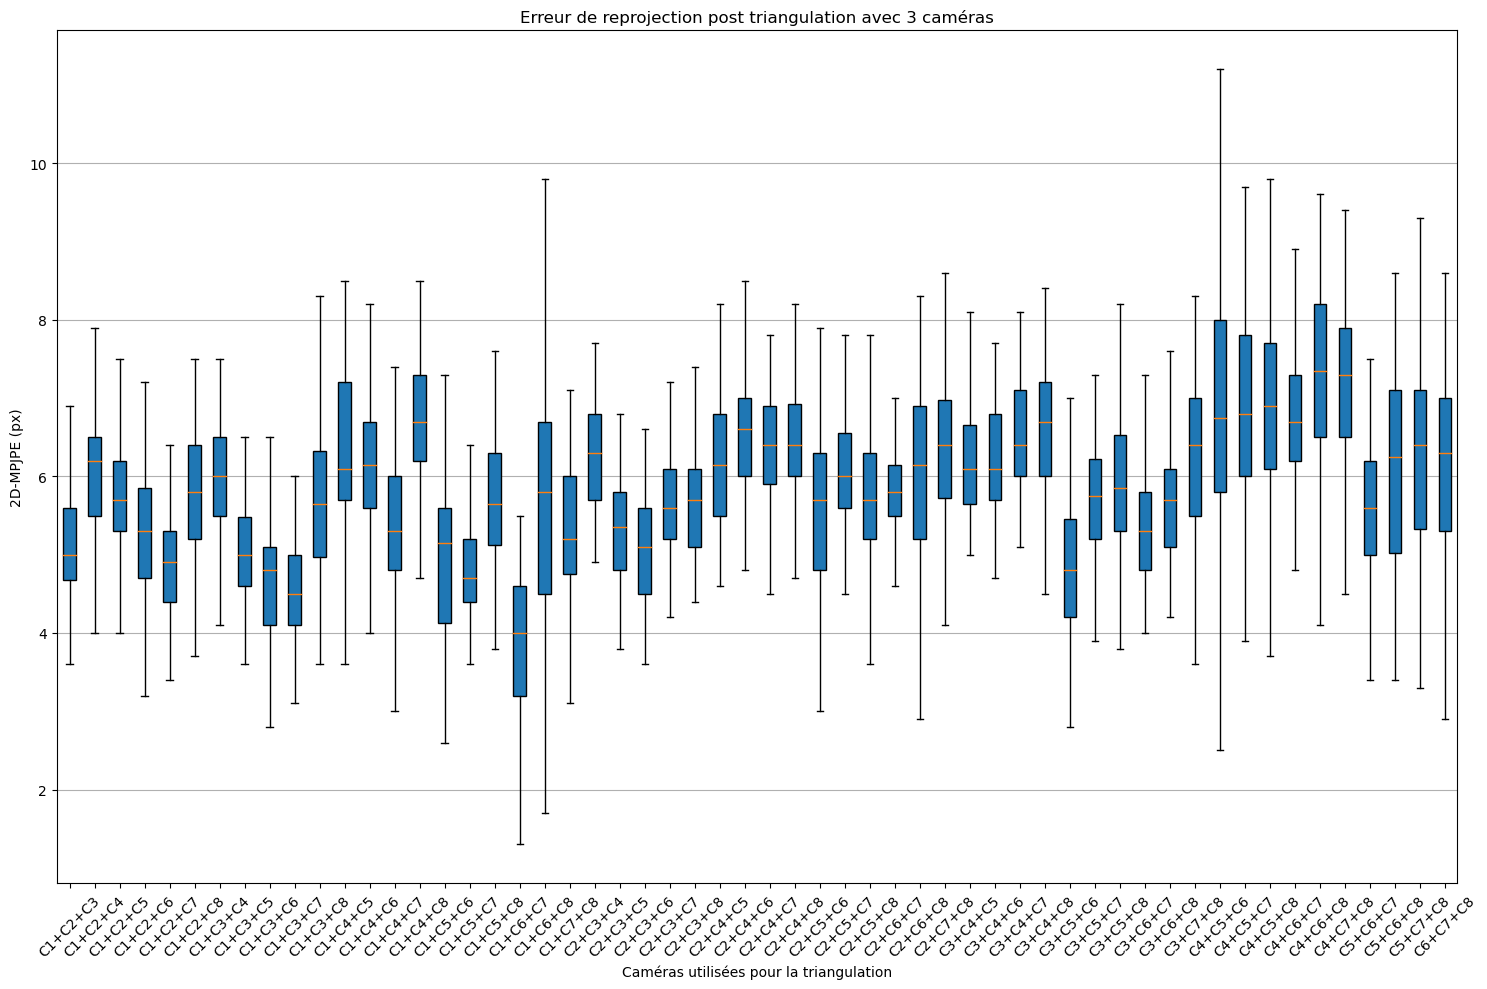

Mean error: 6.87 px


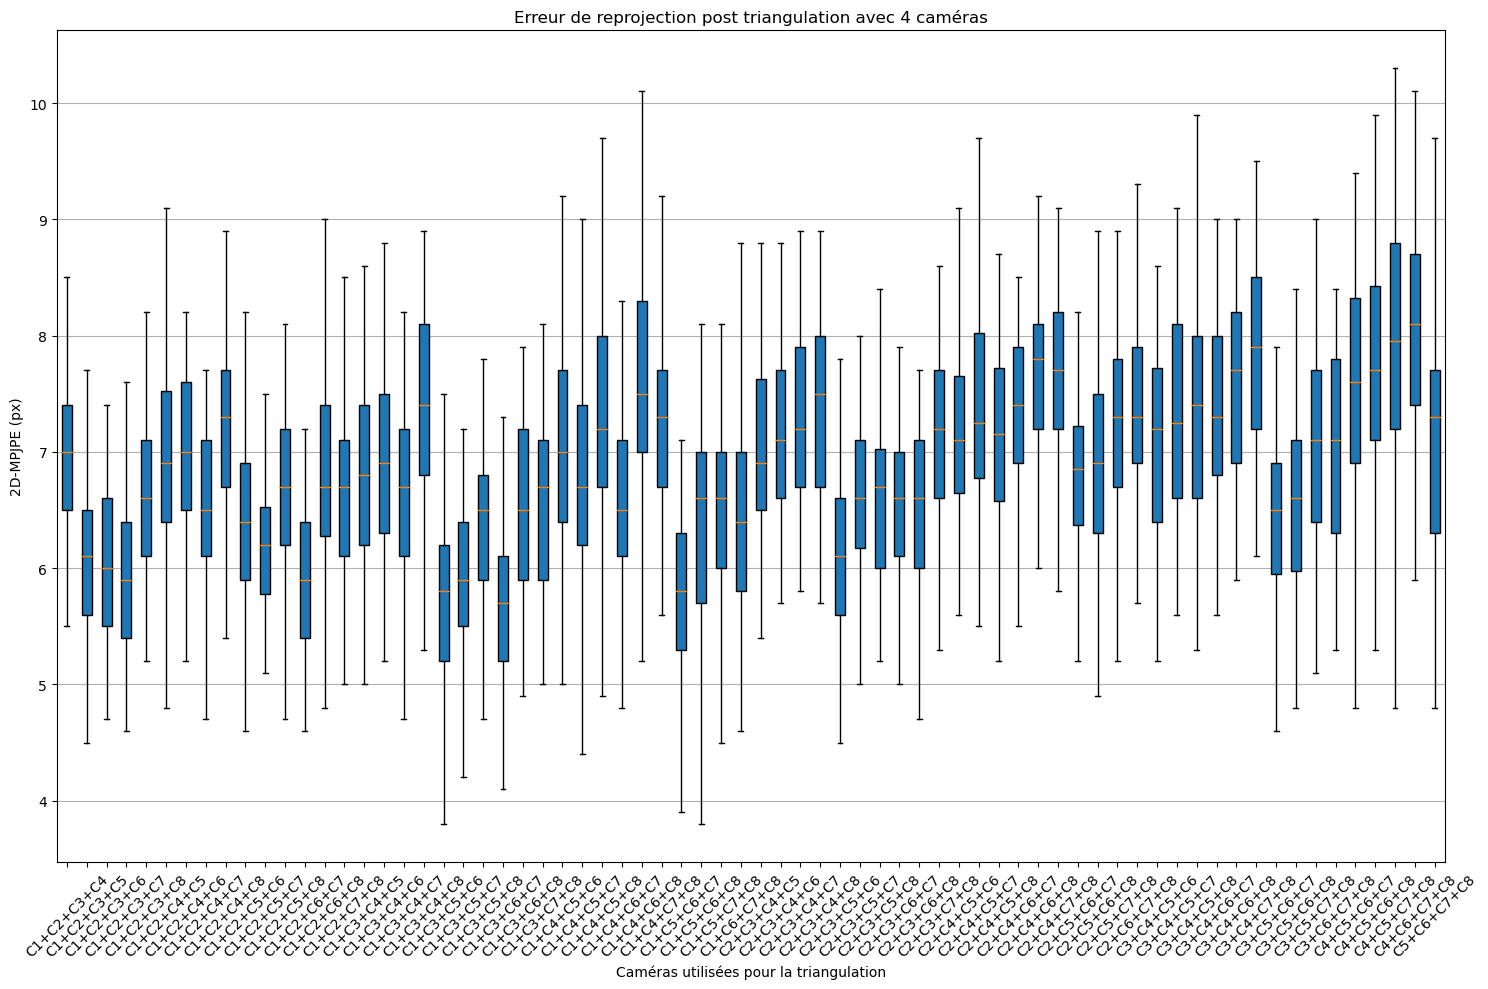

Mean error: 7.59 px


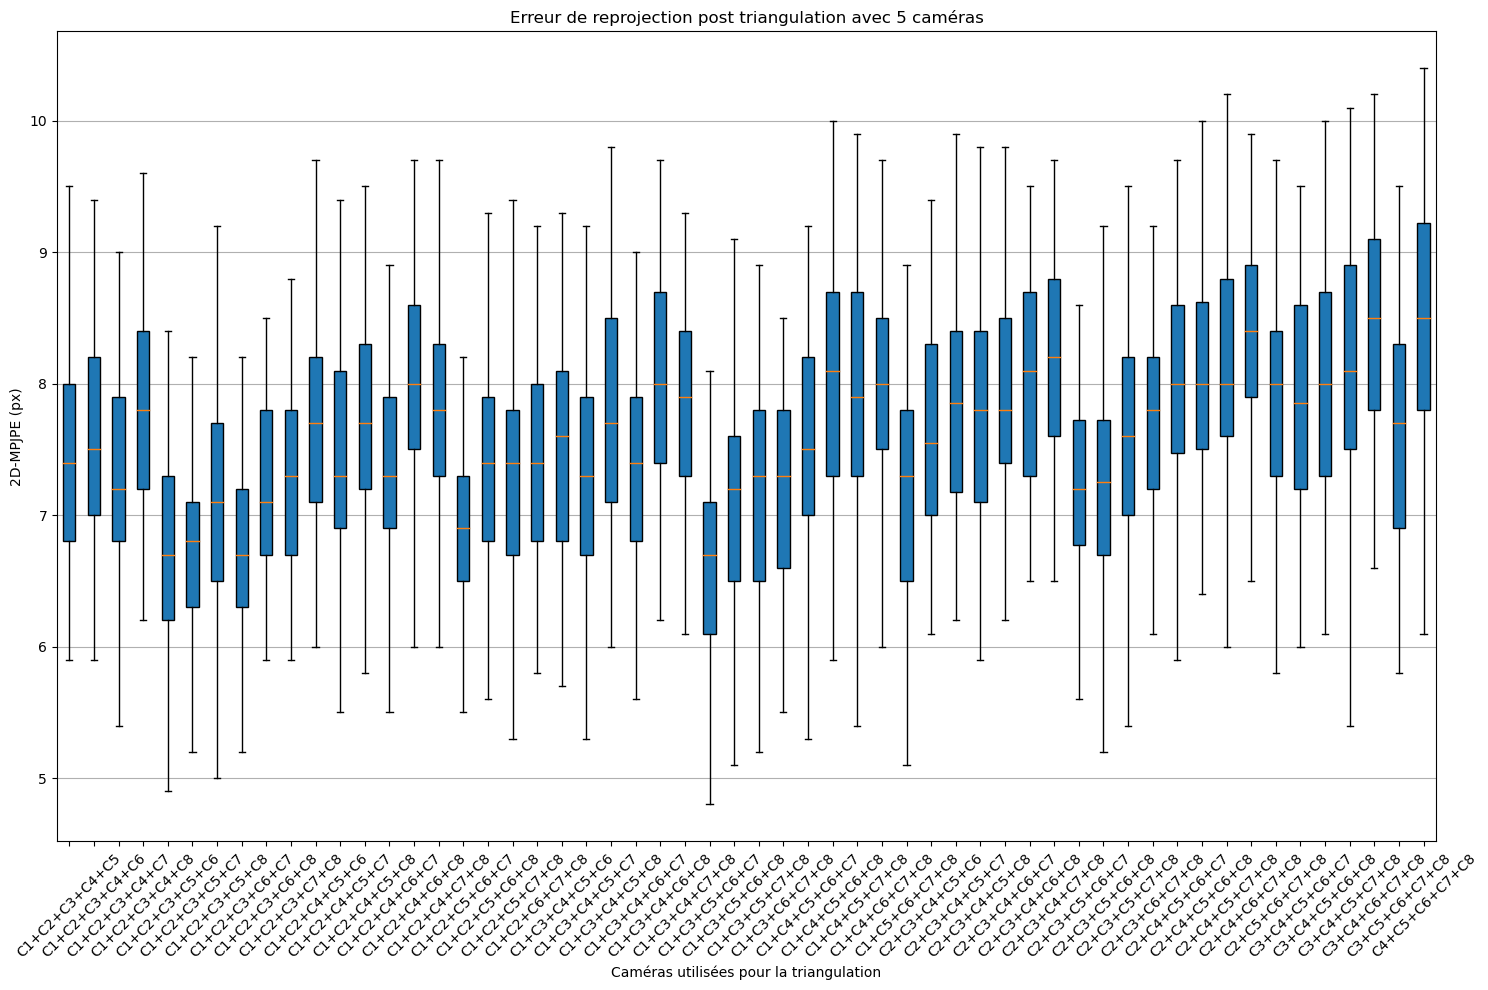

Mean error: 8.13 px


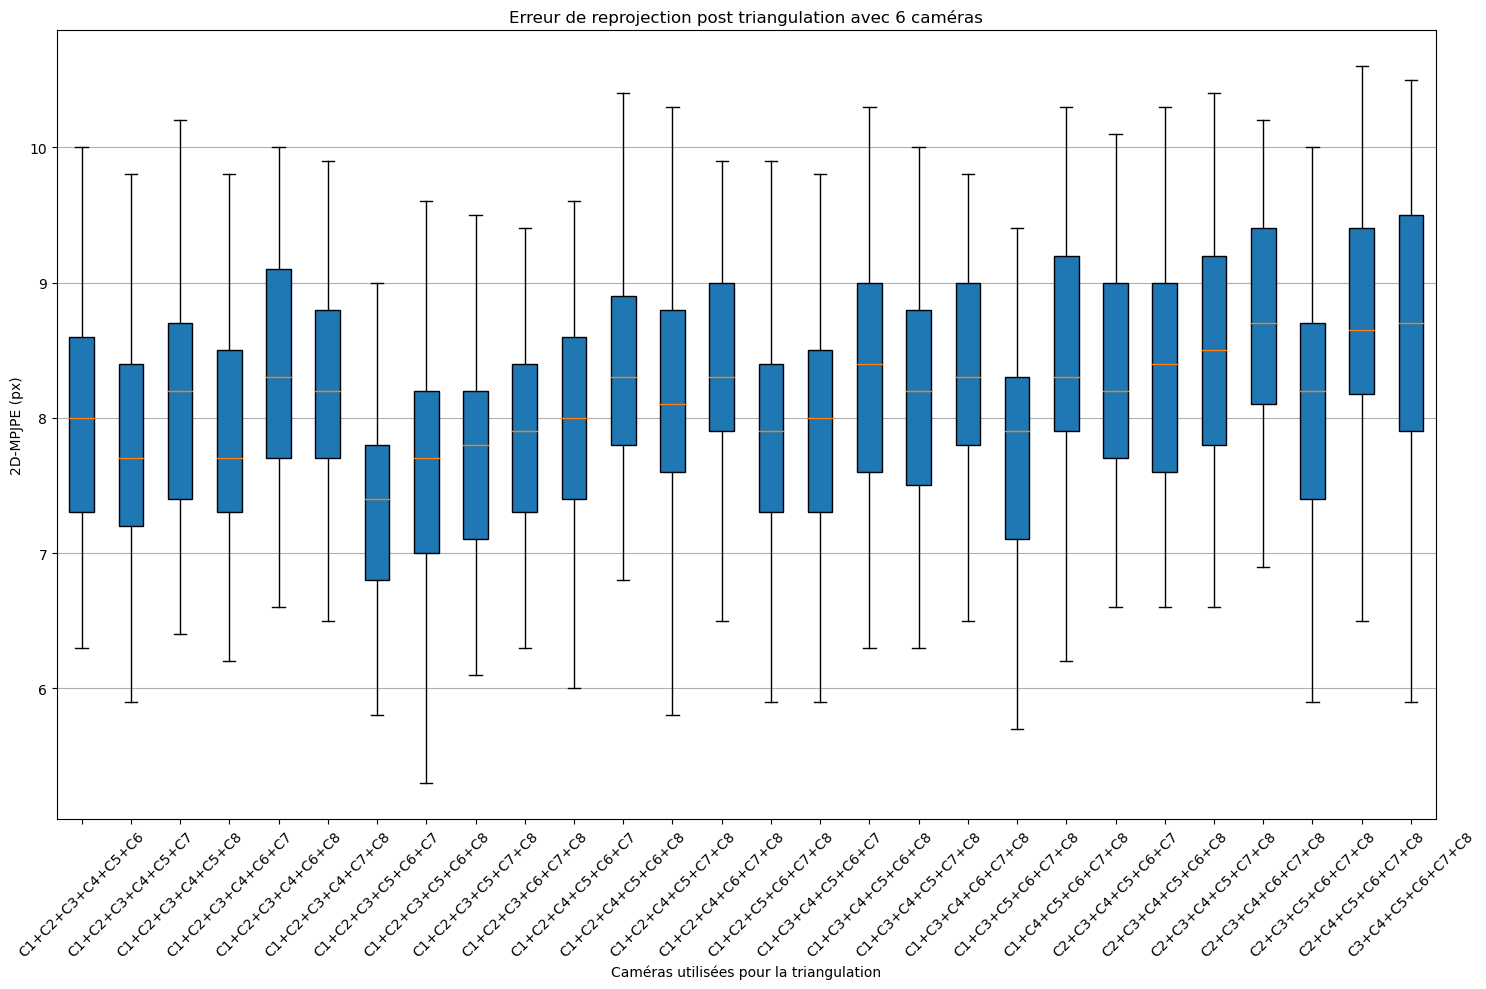

Mean error: 8.55 px


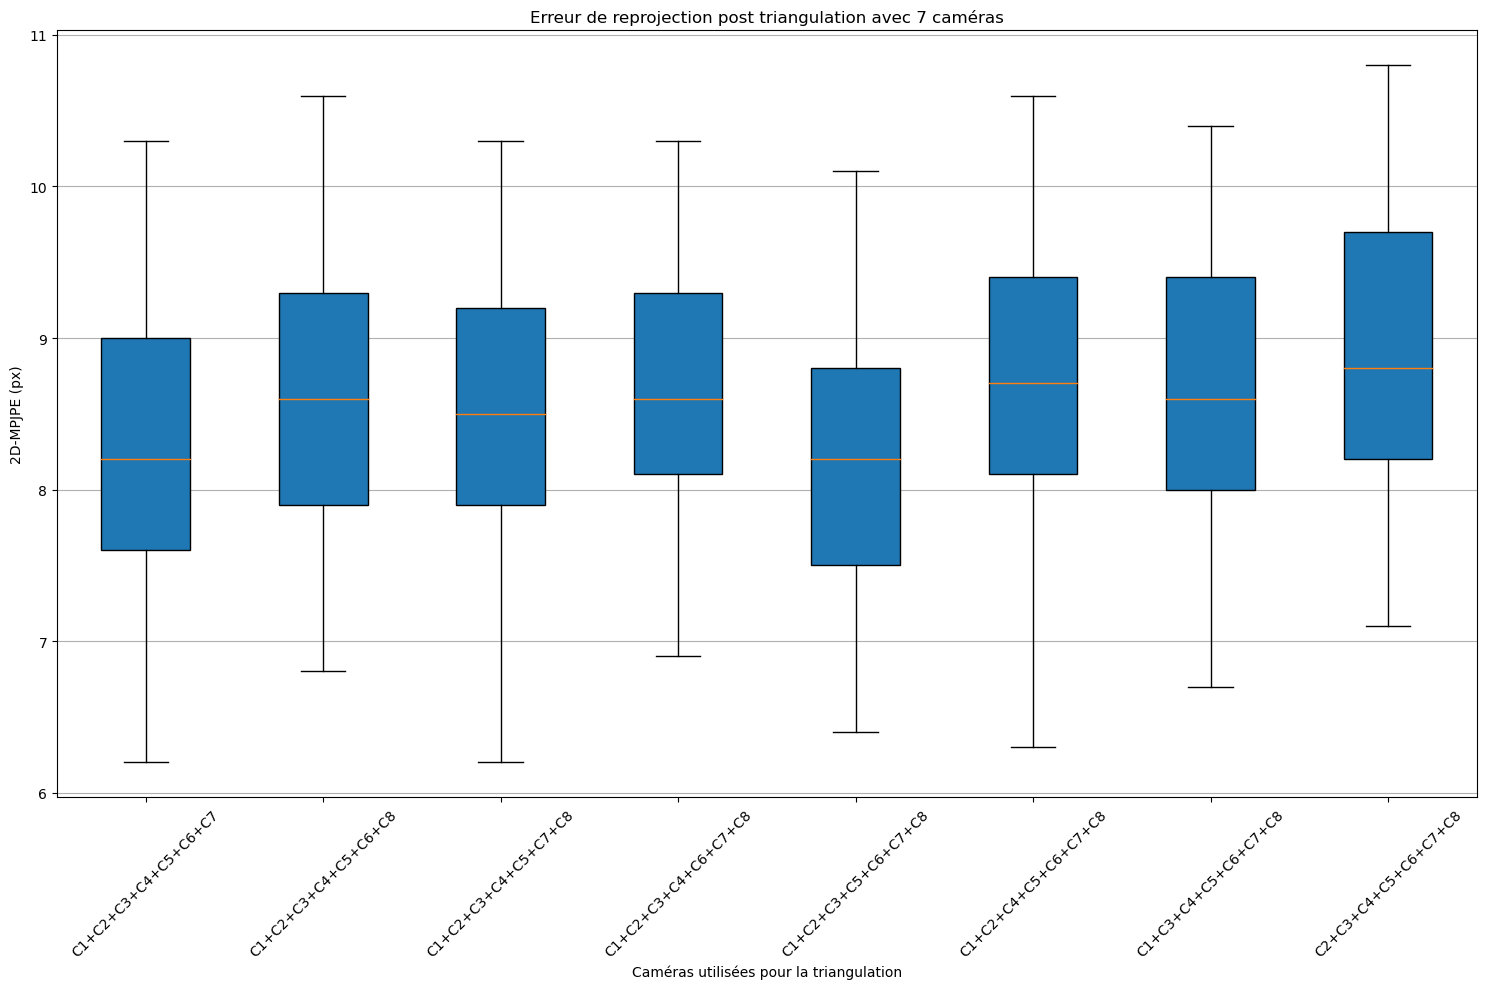

In [6]:
cam_keys = list(errors_seq_cam['2_partie_0429_000'].keys())

errors_all_cam = {i:{} for i in range(2,8)}

for c in cam_keys:
    errors_all_cam[len(c.split('+'))].update({c: []})

for seq, errors_cam in errors_seq_cam.items():
    for cam, error in errors_cam.items():
        try:
            errors_all_cam[len(cam.split('+'))][cam].append(error[0])
        except KeyError:
            continue

for i in range(2,8):
    labels = list(errors_all_cam[i].keys())
    valeurs = list(errors_all_cam[i].values())

    print(f'Mean error: {np.mean(np.concatenate(valeurs)):.2f} px')

    # Boxplot
    plt.figure(figsize=(15, 10))
    plt.boxplot(valeurs, labels=labels, patch_artist=True, showfliers=False)
    plt.xlabel('Caméras utilisées pour la triangulation')
    plt.ylabel('2D-MPJPE (px)')
    plt.title(f'Erreur de reprojection post triangulation avec {i} caméras')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()

    plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/vit_reprog_{i}_cameras.png')
    plt.show()

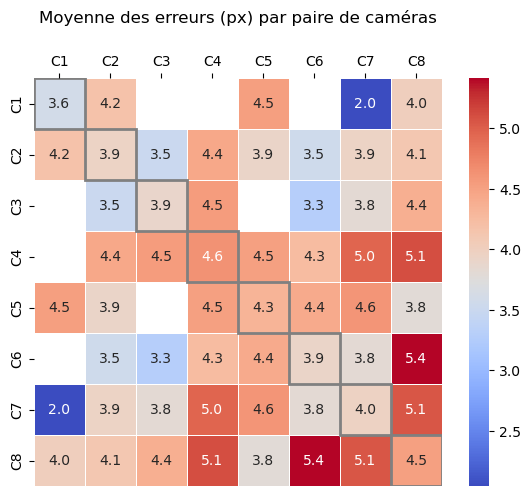

In [7]:
data = errors_all_cam[2]

# --- Étape 1 : détecter les caméras uniques ---
camera_names = sorted({cam for pair in data for cam in pair.split('+')})

# --- Étape 2 : initialiser une matrice NaN ---
matrix = pd.DataFrame(np.nan, index=camera_names, columns=camera_names)

# --- Étape 3 : remplir la matrice avec les moyennes des paires ---
for pair, values in data.items():
    cam1, cam2 = pair.split('+')
    mean_val = np.mean(values)
    matrix.loc[cam1, cam2] = mean_val
    matrix.loc[cam2, cam1] = mean_val  # symétrie

# --- Étape 4 : remplir la diagonale avec la moyenne de chaque caméra ---
for cam in camera_names:
    # Trouver toutes les paires impliquant cette caméra
    associated_values = [
        val for pair, val in data.items()
        if cam in pair.split('+')
        for val in val
    ]
    if associated_values:
        matrix.loc[cam, cam] = np.mean(associated_values)

# --- Étape 5 : heatmap avec labels en haut ---
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    matrix,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    xticklabels=True,
    yticklabels=True
)

# --- Ajouter des carrés autour de la diagonale ---
n = len(camera_names)
for i in range(n):
    rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='grey', linewidth=2)
    ax.add_patch(rect)

# Déplacer les labels des colonnes en haut
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.title("Moyenne des erreurs (px) par paire de caméras", pad=40)
plt.tight_layout()

plt.savefig('/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/matrix_vit.png')
plt.show()

### 3D distance between triangulations according to number of cameras used

In [4]:
path = '/home/lea/trampo/MODELS_2D3D/Pose2Sim/pose-3d-vit-multi'
mpjpe_per_keypoint_list = {}

from compute_CoM import CoM
com_obj = CoM('women', 13)

for seq in os.listdir(path):
    if '0429' in str(seq):
        gt_coords, gt_frames = extract_coordinates(f'{path}/{seq}/GT_8cam/{seq}.trc')

        seq_path = os.path.join(path, seq)
        mpjpe_per_keypoint_list.update({seq: {cam_label:[] for cam_label in sorted(os.listdir(seq_path))}})

        for cam_label in sorted(os.listdir(seq_path)):
            file = os.path.join(seq_path, cam_label, f'{seq}.trc')
            coords, pred_frames = extract_coordinates(file)

            common_frames = np.intersect1d(gt_frames, pred_frames)
            if common_frames.shape[0] > 0:
                gt_indices = [np.where(gt_frames == f)[0][0] for f in common_frames]
                pred_indices = [np.where(pred_frames == f)[0][0] for f in common_frames]

                errors = np.linalg.norm(gt_coords[gt_indices] - coords[pred_indices], axis=2)
                errors[errors > 1000] = np.nan

                mpjpe_per_keypoint = np.nanmean(errors, axis=0)
                mpjpe_per_keypoint_list[seq][cam_label] = mpjpe_per_keypoint
            else:
                mpjpe_per_keypoint = np.full(gt_coords.shape[1], np.nan)

            """ if common_frames.shape[0] > 0:
                gt_indices = [np.where(gt_frames == f)[0][0] for f in common_frames]
                pred_indices = [np.where(pred_frames == f)[0][0] for f in common_frames]

                # Filtrer les frames aberrantes selon le centre de masse global
                valid_idx = []
                for gi, pi in zip(gt_indices, pred_indices):
                    gt_cm = com_obj.compute_global_cm(gt_coords[gi])       # centre de masse GT
                    pred_cm = com_obj.compute_global_cm(coords[pi])        # centre de masse prédiction
                    dist_cm = np.linalg.norm(gt_cm - pred_cm)           # distance euclidienne entre CM
                    if dist_cm <= 1000:                                 # seuil 1000 mm
                        valid_idx.append((gi, pi))

                if valid_idx:  # si au moins une frame passe le filtre
                    gt_valid, pred_valid = zip(*valid_idx)
                    errors = np.linalg.norm(gt_coords[list(gt_valid)] - coords[list(pred_valid)], axis=2)

                    mpjpe_per_keypoint = np.mean(errors, axis=0)
                else:
                    mpjpe_per_keypoint = np.full(gt_coords.shape[1], np.nan)

                mpjpe_per_keypoint_list[seq][cam_label] = mpjpe_per_keypoint
            else:
                mpjpe_per_keypoint = np.full(gt_coords.shape[1], np.nan) """

# Regrouper par caméra
mpjpe_per_keypoint_merged = defaultdict(list)

for seq, cams in mpjpe_per_keypoint_list.items():
    for cam_label, values in cams.items():
        mpjpe_per_keypoint_merged[cam_label].extend(values)

/tmp/ipykernel_3968783/206107389.py:26: RuntimeWarning: Mean of empty slice
  mpjpe_per_keypoint = np.nanmean(errors, axis=0)


2 cameras
Means:   min = 76.1, med = 103.0, max = 172.1
Medians: min = 43.8, med = 91.4, max = 172.3


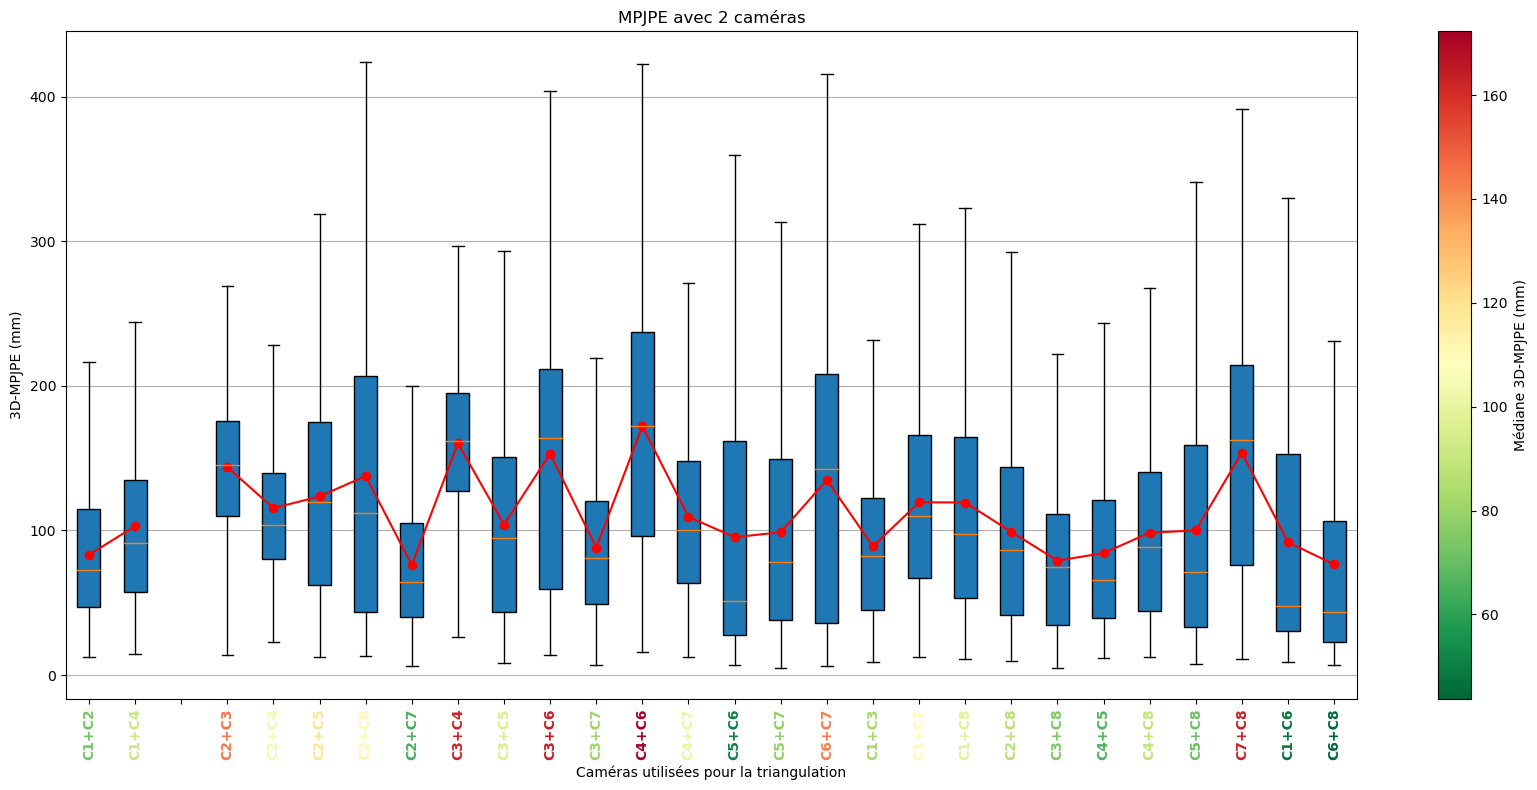

3 cameras
Means:   min = 64.6, med = 88.9, max = 134.8
Medians: min = 56.2, med = 82.2, max = 138.3


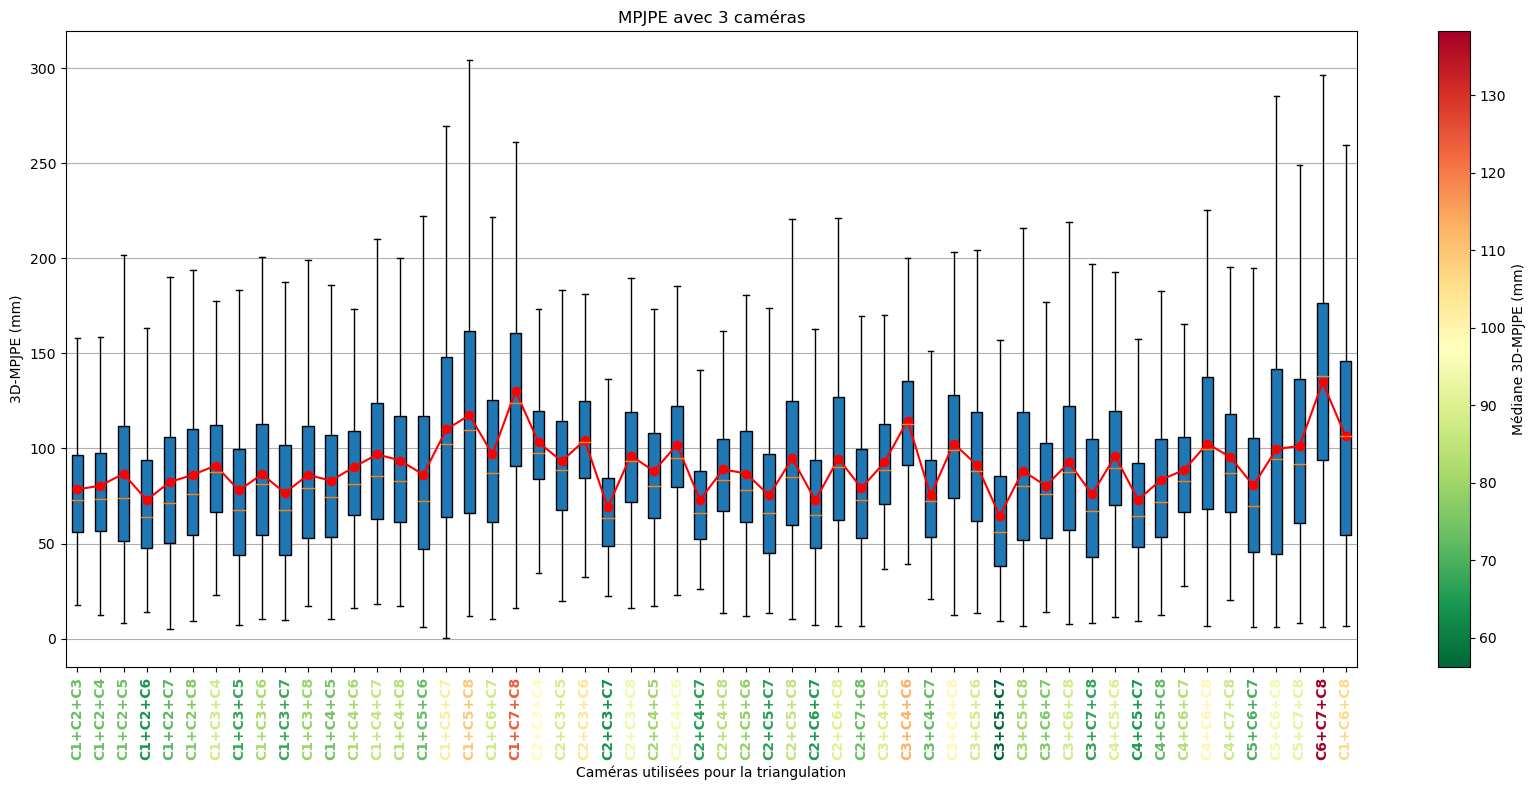

4 cameras
Means:   min = 53.2, med = 69.0, max = 112.5
Medians: min = 47.1, med = 61.5, max = 100.8


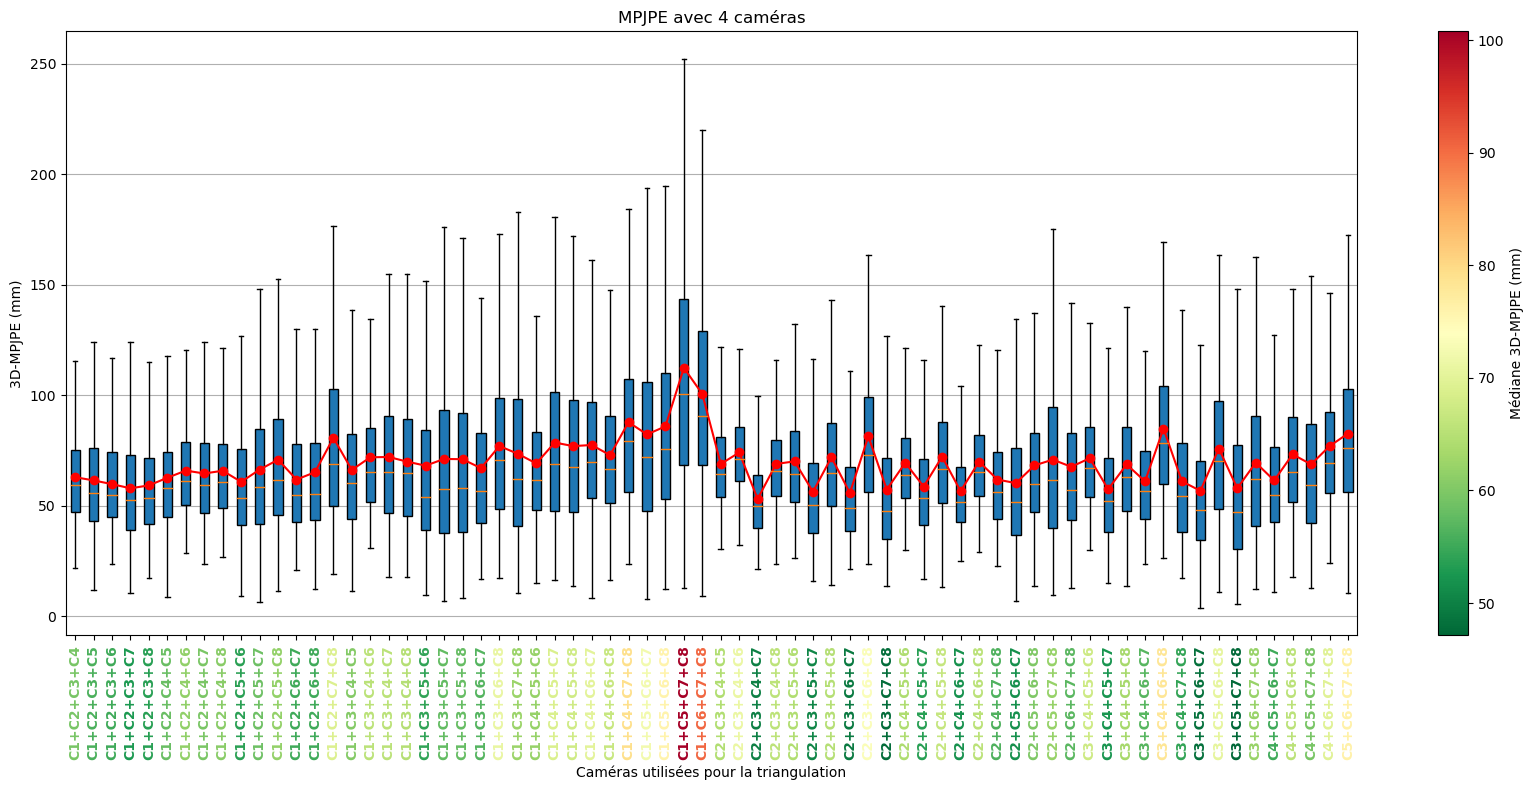

5 cameras
Means:   min = 35.4, med = 49.1, max = 69.2
Medians: min = 33.1, med = 43.4, max = 58.8


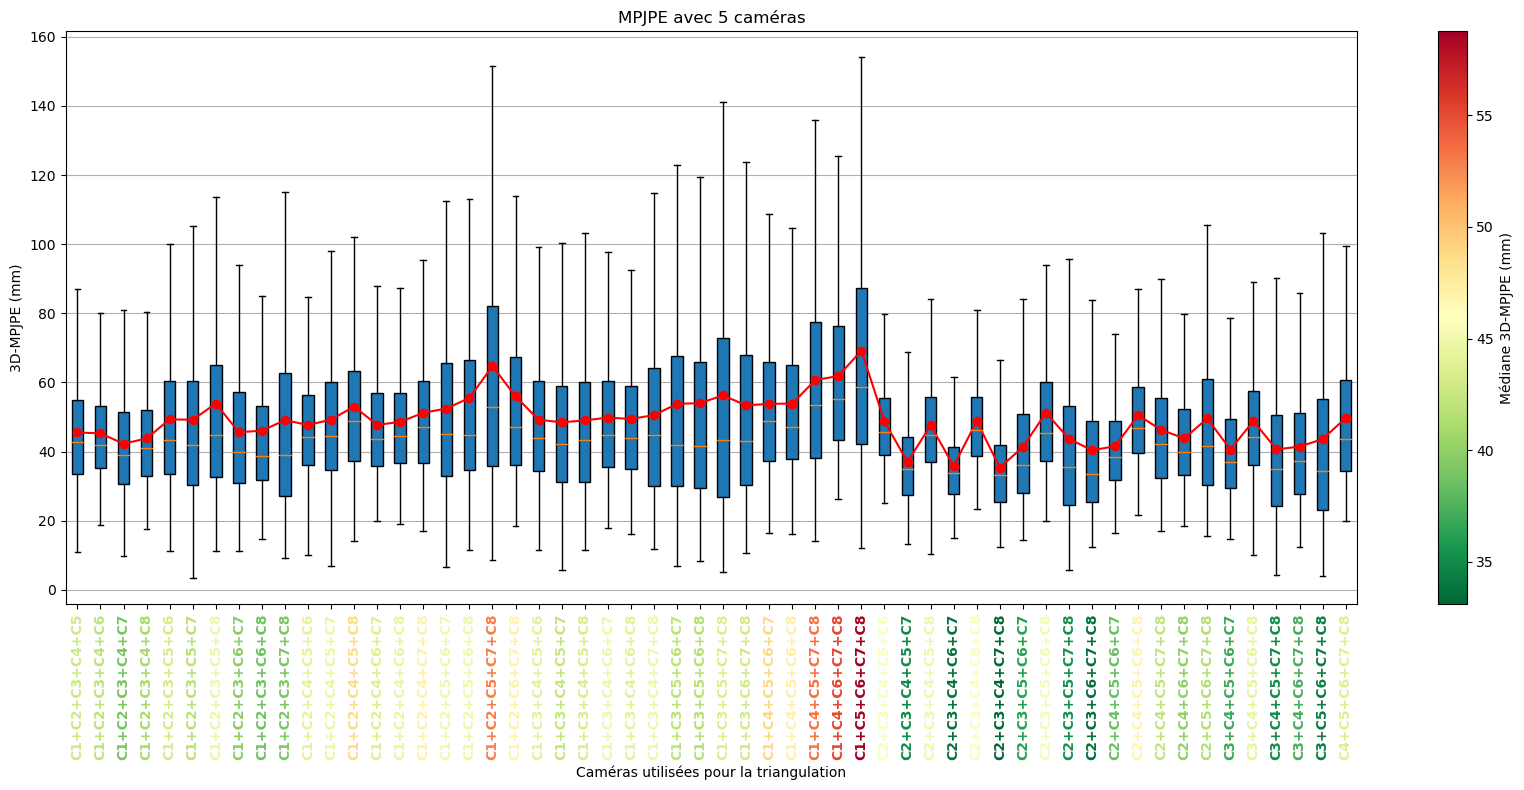

6 cameras
Means:   min = 19.7, med = 31.9, max = 41.9
Medians: min = 18.4, med = 28.4, max = 36.5


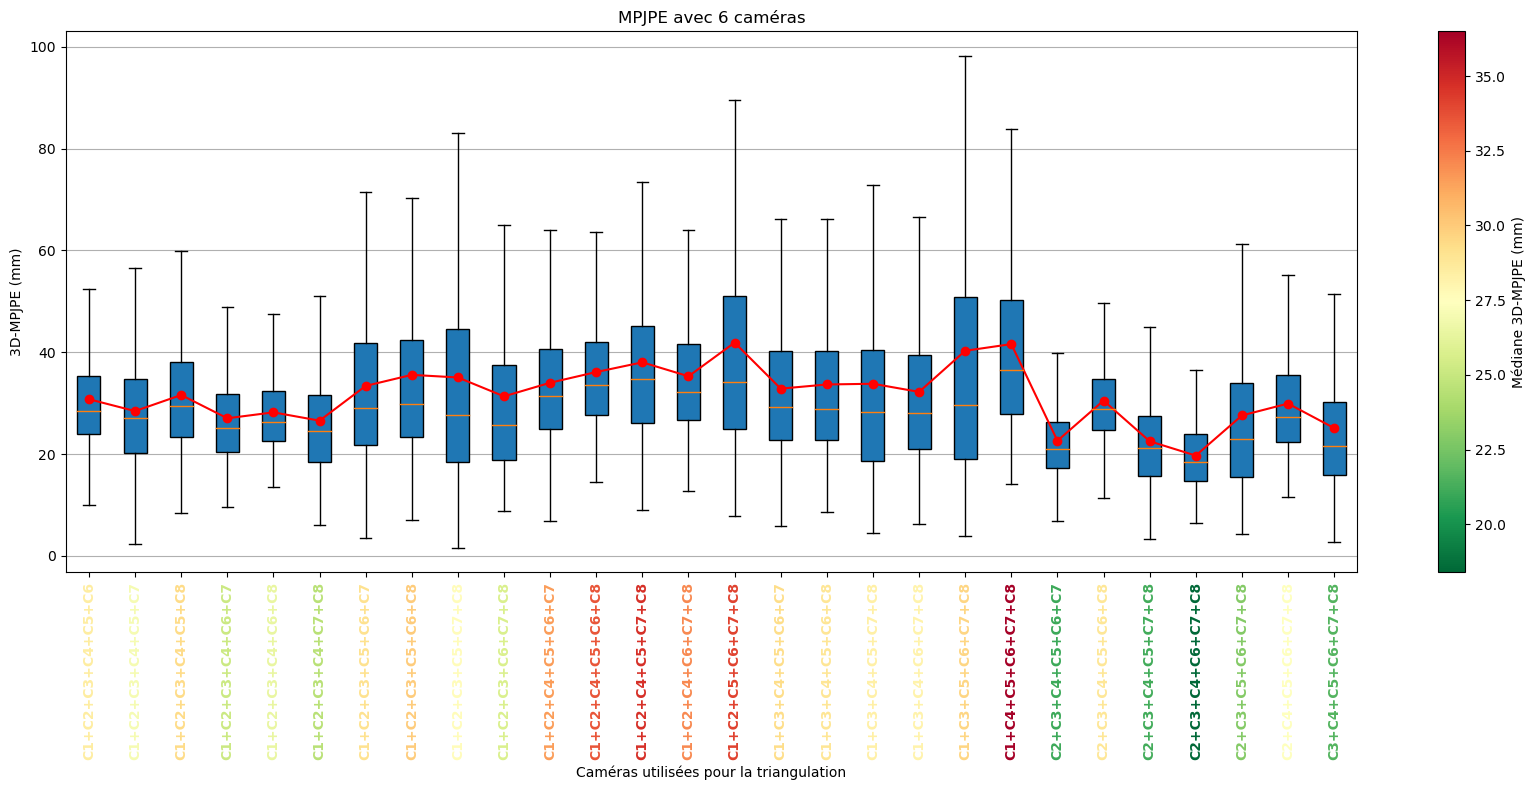

7 cameras
Means:   min = 8.0, med = 16.0, max = 23.0
Medians: min = 7.3, med = 14.3, max = 21.1


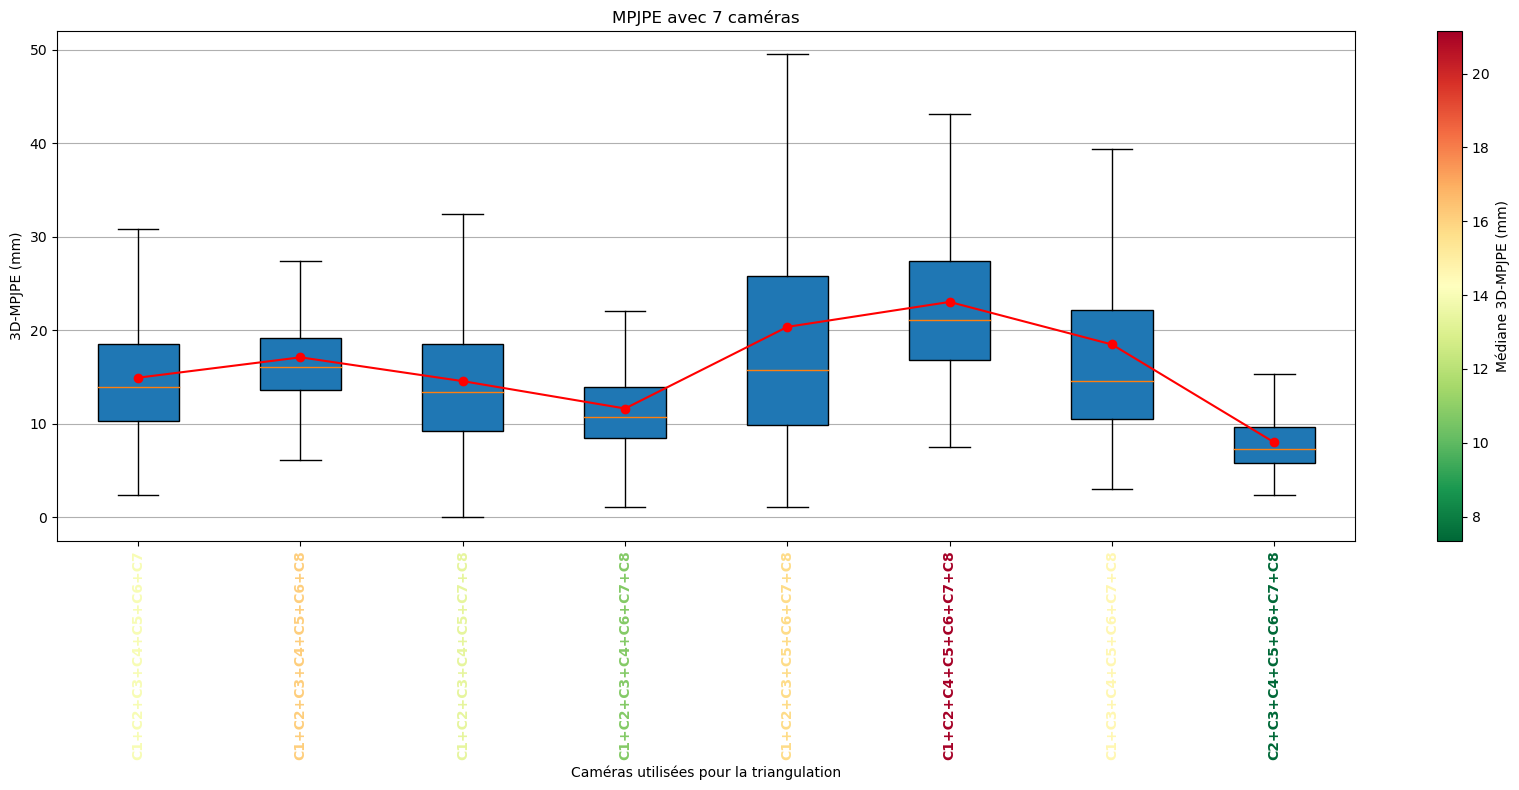

In [5]:
plt.close()
for i in range(2, 8):
    labels = [k for k in mpjpe_per_keypoint_merged.keys() if len(k.split('+')) == i]
    valeurs = [np.ravel(v) for k, v in mpjpe_per_keypoint_merged.items() if len(k.split('+')) == i]

    # Médianes pour chaque combinaison
    medians = [np.median(v) for v in valeurs]
    means = [np.mean(v) for v in valeurs]

    means = np.array(means)
    print(i, 'cameras')
    print(f'Means:   min = {np.nanmin(means):.1f}, med = {np.nanmedian(means):.1f}, max = {np.nanmax(means):.1f}')

    medians = np.array(medians)
    print(f'Medians: min = {np.nanmin(medians):.1f}, med = {np.nanmedian(medians):.1f}, max = {np.nanmax(medians):.1f}')

    # Normalisation et colormap
    norm = plt.Normalize(min(medians), max(medians))
    cmap = plt.colormaps['RdYlGn_r']  # rouge = mauvais, vert = bon

    fig, ax = plt.subplots(figsize=(17, 8))
    ax.boxplot(valeurs, labels=labels, patch_artist=True, showfliers=False)
    ax.plot(range(1, len(means) + 1), means, 'r-o', label='Moyenne')

    # Appliquer les couleurs aux labels
    for label, m in zip(ax.get_xticklabels(), medians):
        label.set_color(cmap(norm(m)))
        label.set_fontweight('bold')

    ax.set_xlabel('Caméras utilisées pour la triangulation')
    ax.set_ylabel('3D-MPJPE (mm)')
    ax.set_title(f'MPJPE avec {i} caméras')
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.grid(axis='y')

    # Ajouter la colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # nécessaire pour la colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Médiane 3D-MPJPE (mm)')

    plt.tight_layout()
    plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/vit_3dMPJPE_{i}_cameras_filtCoM.png')
    plt.show()

plt.close()


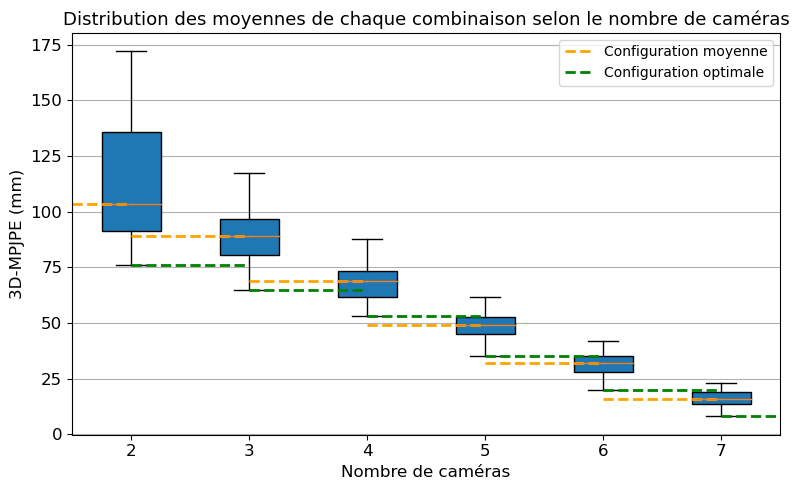

In [6]:
means_per_ncam = []
n_cams = range(2, 8)

for i in n_cams:
    # Moyenne par combinaison
    comb_means = [np.nanmean(v) for k, v in mpjpe_per_keypoint_merged.items() if len(k.split('+')) == i]
    means_per_ncam.append(comb_means)

# Boxplot des moyennes par combinaison
fig, ax = plt.subplots(figsize=(8,5))
bp = plt.boxplot(means_per_ncam, labels=n_cams, patch_artist=True, showfliers=False)

# Moyenne, médiane et min globaux par nombre de caméras
global_means = [np.nanmean(m) for m in means_per_ncam]
global_medians = [np.nanmedian(m) for m in means_per_ncam]
global_mins = [np.nanmin(m) for m in means_per_ncam]

# Ajouter lignes horizontales locales (orange = min, gris = médiane)
for x, (ymin, ymed) in enumerate(zip(global_mins, global_medians), start=1):
    plt.hlines(y=ymin, xmin=x, xmax=x+1, colors='green', linestyles='--', linewidth=2, label='Configuration optimale')
    plt.hlines(y=ymed, xmin=x-1, xmax=x, colors='orange', linestyles='--', linewidth=2, label='Configuration moyenne')

plt.xlim(0.5, 6.5)
plt.xlabel('Nombre de caméras', fontsize=12)
plt.ylabel('3D-MPJPE (mm)', fontsize=12)
plt.title('Distribution des moyennes de chaque combinaison selon le nombre de caméras', fontsize=13)
plt.grid(axis='y')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(ul)] for ul in unique_labels]

ax.legend(unique_handles, unique_labels)

plt.tight_layout()
plt.show()


In [7]:
medians = [59.755496046465225, 59.930344896130336, 55.84571253180731, 58.34002940296539, 55.16708964897089, 58.903267512553036, 59.52901112196596, 60.30660745776271, 61.63167607185662, 55.82785850060878, 66.32531480333581, 73.52153160176212, 58.37569630457575, 55.26955602337982, 69.04702186272779, 60.46765848819261, 65.55533555199668, 65.4909903639277, 64.93609964793838, 54.23099072206792, 57.70983493694964, 57.93846408125097, 56.668552777105546, 70.90006960426926, 62.33866347952979, 61.88762072423317, 68.82844252832668, 67.61458409234058, 70.1175510734673, 66.80574041828686, 79.2029244136883, 72.16455595397358, 75.92295498981254, 100.78739467971016, 90.7186746631159, 64.4598068378564, 71.17363123740961, 49.84957292990838, 65.6415380453874, 64.42801235385053, 50.51686305998429, 64.78945403473597, 49.07426588776588, 73.2017669314813, 47.549395368779265, 64.19254839907896, 53.44816988056908, 66.56460969601699, 51.76177602054314, 65.49162845654891, 56.18605345411447, 51.60273101081769, 59.98984073642542, 61.859977272028175, 57.158380170709364, 67.28485611726808, 52.16649537187416, 63.28268653552276, 56.8069267151927, 78.3300211192737, 54.41564628741376, 47.989725109417165, 70.40173869228781, 47.12122301043713, 62.070841095752996, 55.08822597726622, 65.44828272931119, 59.458787193930604, 69.56593009852949, 76.2902606218831]
means = [63.33791636800607, 70.51019907302214, 63.33559213126966, 67.05650725405918, 64.34564652141192, 64.74278357122394, 64.69464256605912, 66.09935038678037, 68.9383523544092, 66.63506083959464, 79.21432146023312, 85.31556784113204, 66.34711240747504, 65.25196847437547, 80.8518723391109, 66.31414606938607, 72.01913795333664, 72.17350912034384, 70.04718074864479, 68.22777364542435, 71.27779280453366, 71.16192024790655, 67.11265215901341, 77.11560788373392, 73.59183747331579, 69.24366913899726, 78.68859061882698, 77.0869997641147, 77.58313222095136, 72.98483764737158, 87.90613091563053, 82.36369562040254, 86.01212208029891, 112.49141351215947, 100.65119964040628, 68.98651677175482, 74.19444675640149, 53.21439554241053, 69.0137742617138, 70.18121519572507, 56.428419151775934, 72.01849284787248, 55.896448184177196, 81.46557049081956, 57.43011651435271, 69.55589929169464, 58.78670208949293, 72.29054888906059, 56.723301344488874, 70.04840464807182, 61.94716814561924, 60.33657997779433, 68.32711225654361, 70.96632093833098, 67.7327618762226, 71.57805611484183, 57.57689724463353, 68.78989151448629, 61.160917839407915, 84.99688018246012, 61.1768518543962, 56.83731457136606, 75.9923369819045, 58.00952772330045, 69.5977174930094, 61.54251804231999, 73.36650541990551, 68.82621560167897, 77.05210311730346, 82.7641046759597]
means = np.array(means)
print(means.min(), means.max())

medians = np.array(medians)
print(medians.min(), medians.max())

53.21439554241053 112.49141351215947
47.12122301043713 100.78739467971016


[13, 0, 0, 0, 0, 0] [22295, 62907, 80379, 64597, 32370, 9256] [0.05830904 0.         0.         0.         0.         0.        ]
[114.86320561458932, 90.57383883191298, 69.5231852509352, 48.858452120956, 31.646848173972536, 16.023381183961817]
[103.03099735971804, 83.16629079764049, 61.767304966459385, 42.68876045988018, 27.739818784617622, 13.970690453212596]


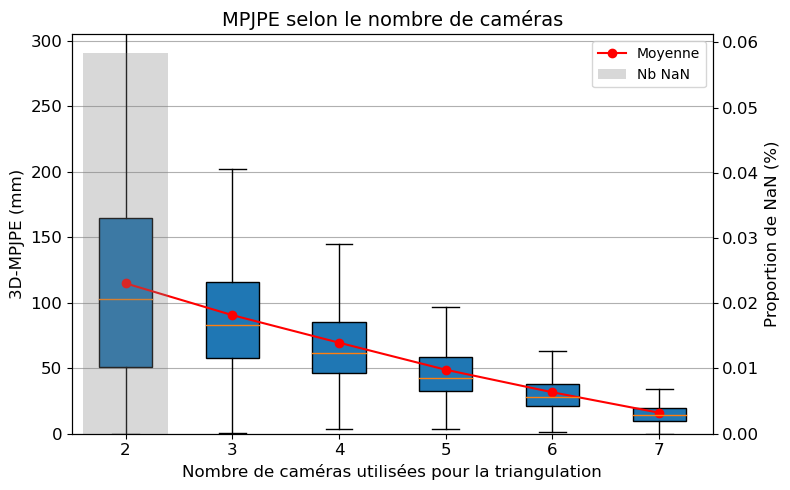

In [8]:
labels = []
valeurs = []
mean_values = []
median_values = []
nan_counts = []
counts = []

for i in range(2, 8):
    labels.append(i)
    group_values = [v for k, v in mpjpe_per_keypoint_merged.items() if len(k.split('+')) == i]
    group_values = np.concatenate(group_values, axis=0)

    # Compter les NaN
    nan_counts.append(np.isnan(group_values).sum())
    counts.append(group_values.shape[0])

    # Supprimer NaN pour les stats
    clean_values = group_values[~np.isnan(group_values)]

    valeurs.append(clean_values)
    mean_values.append(np.nanmean(group_values))  # identique à mean(clean_values)
    median_values.append(np.nanmedian(group_values))

nan_proportion = np.array(nan_counts) / np.array(counts) *100
print(nan_counts, counts, nan_proportion)

print(mean_values)
print(median_values)
# --- Plot principal ---
fig, ax1 = plt.subplots(figsize=(8, 5))

# Boxplot sans NaN
ax1.boxplot(valeurs, labels=labels, patch_artist=True, showfliers=False)
ax1.plot(range(1, len(mean_values) + 1), mean_values, 'r-o', label='Moyenne')

ax1.set_xlabel('Nombre de caméras utilisées pour la triangulation', fontsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_ylabel('3D-MPJPE (mm)', fontsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(0, 305)
ax1.set_title('MPJPE selon le nombre de caméras', fontsize=14)
ax1.grid(axis='y')

# --- Deuxième axe pour NaN ---
if (np.array(nan_counts) > 1).any():
    ax2 = ax1.twinx()
    ax2.bar(range(1, len(labels) + 1), nan_proportion, 
            alpha=0.3, color='gray', label='Nb NaN')
    ax2.set_ylabel('Proportion de NaN (%)', fontsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    # Légendes combinées
    lines, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels1 + labels2, loc='upper right')

else:
    ax1.legend()

plt.tight_layout()
plt.savefig(f'/home/lea/trampo/metrics/Pose2Sim_triangulation_figs/vit_3dMPJPE_N_cameras.png')
plt.show()

--- C1 ---
--- C2 ---
--- C3 ---
--- C4 ---
--- C5 ---
--- C6 ---
--- C7 ---
--- C8 ---


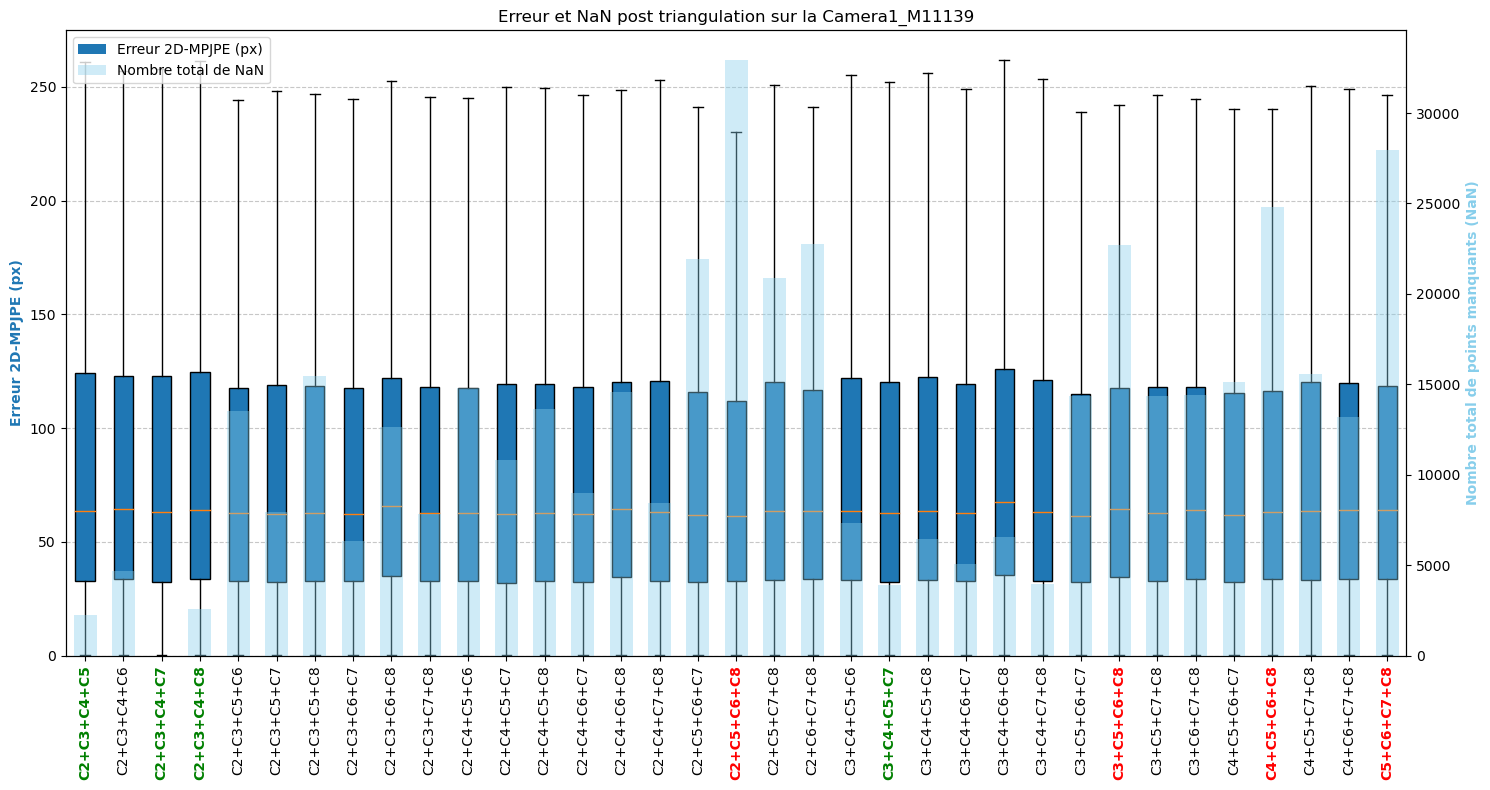

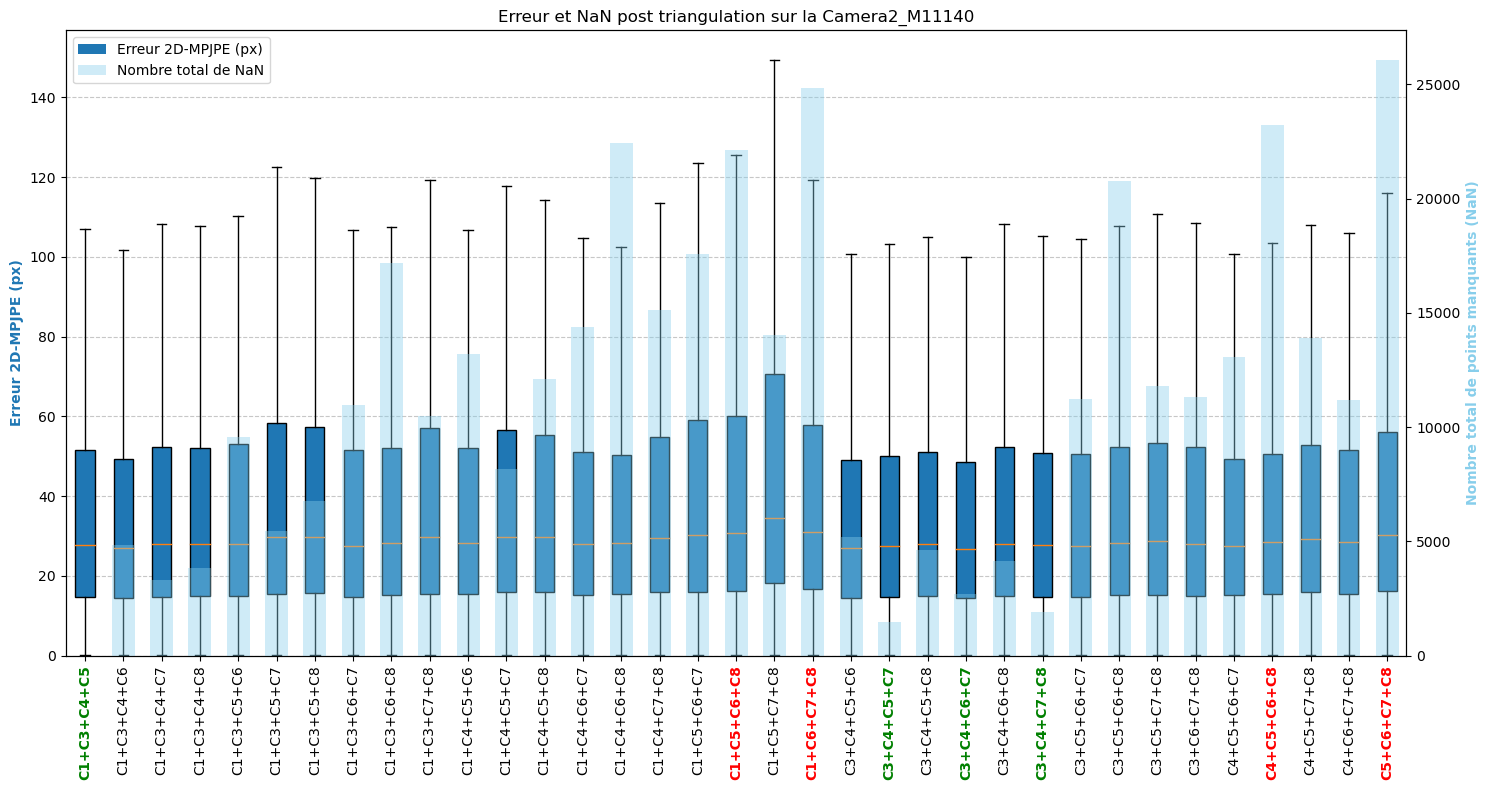

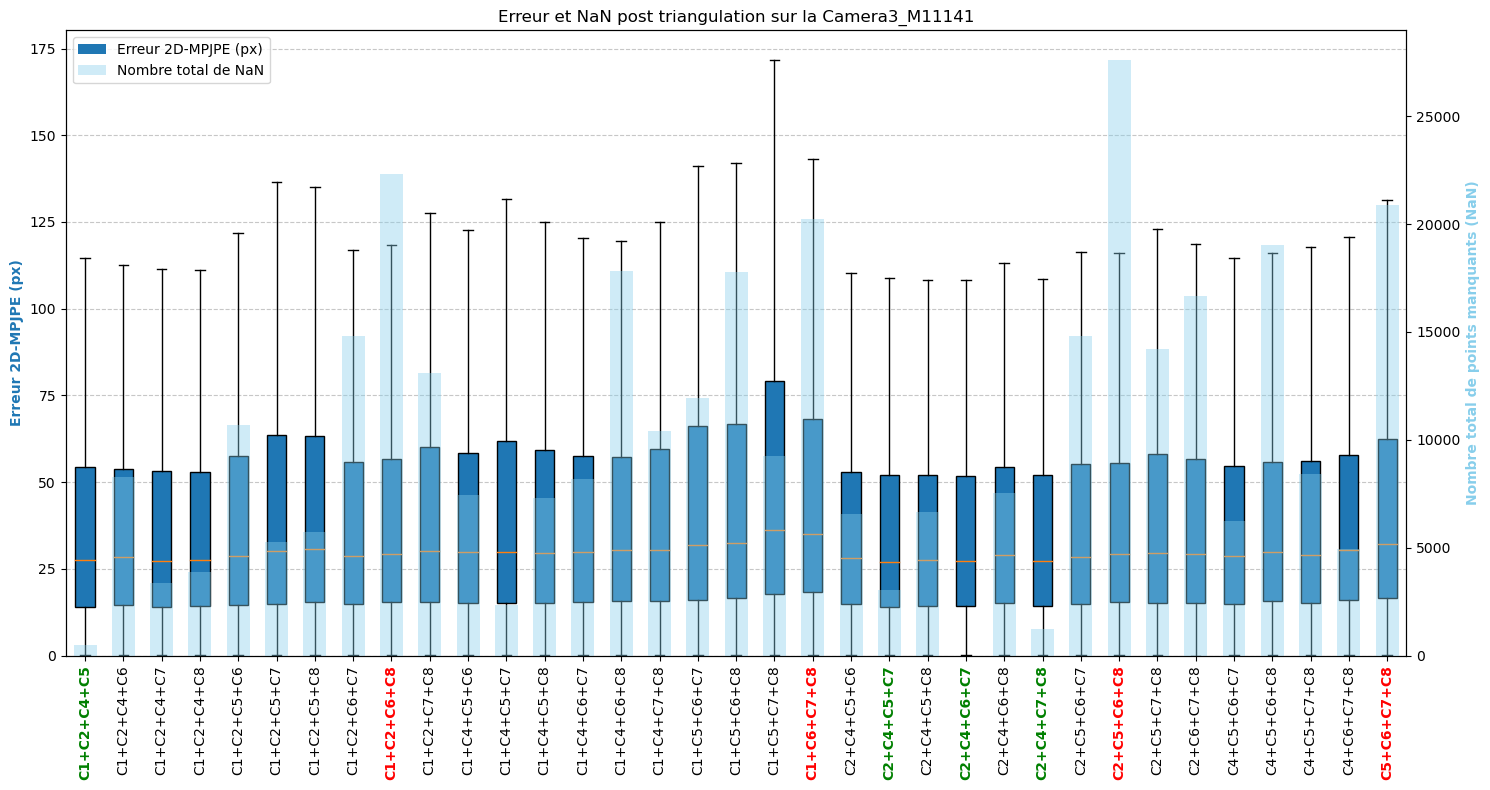

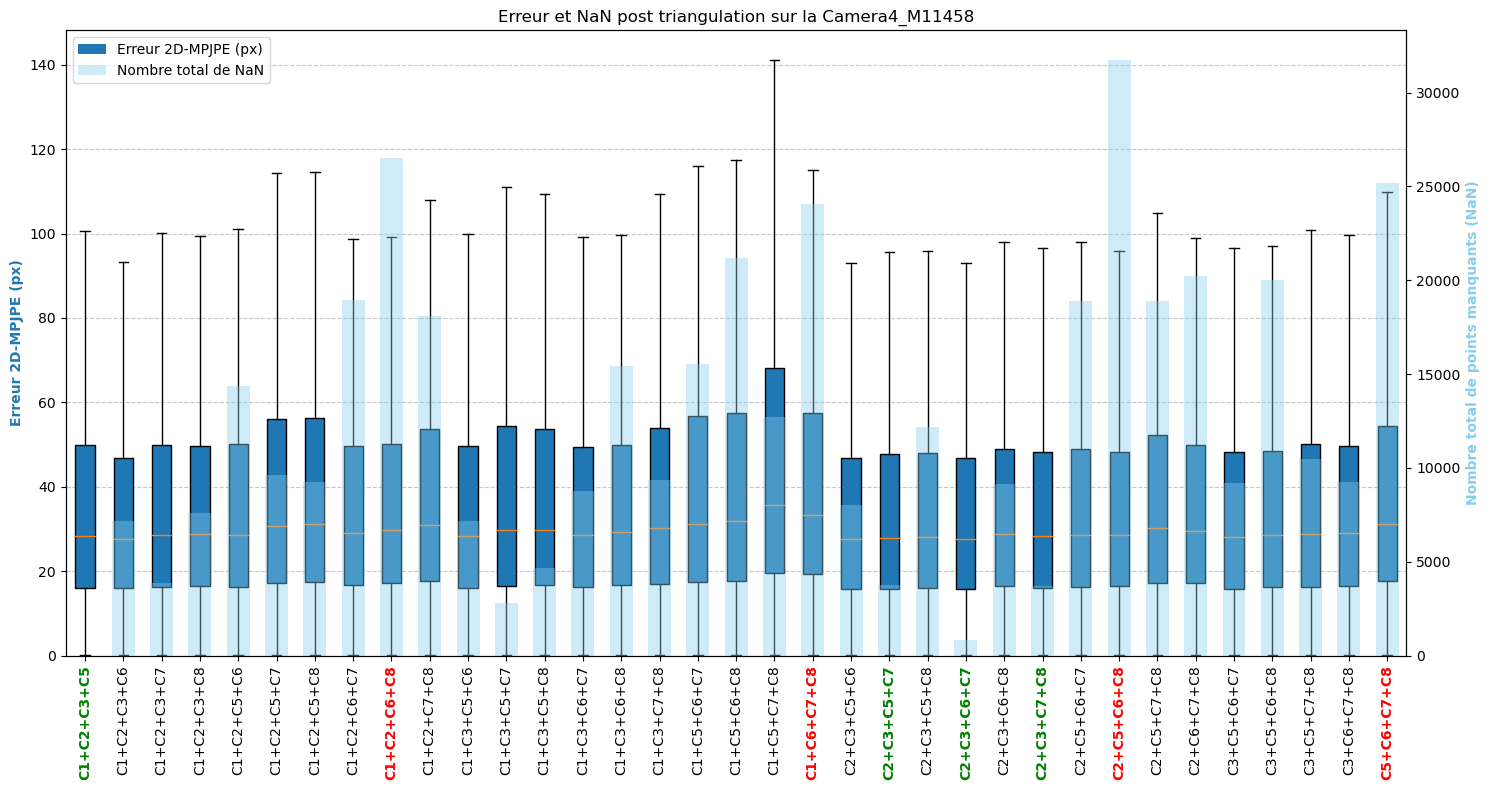

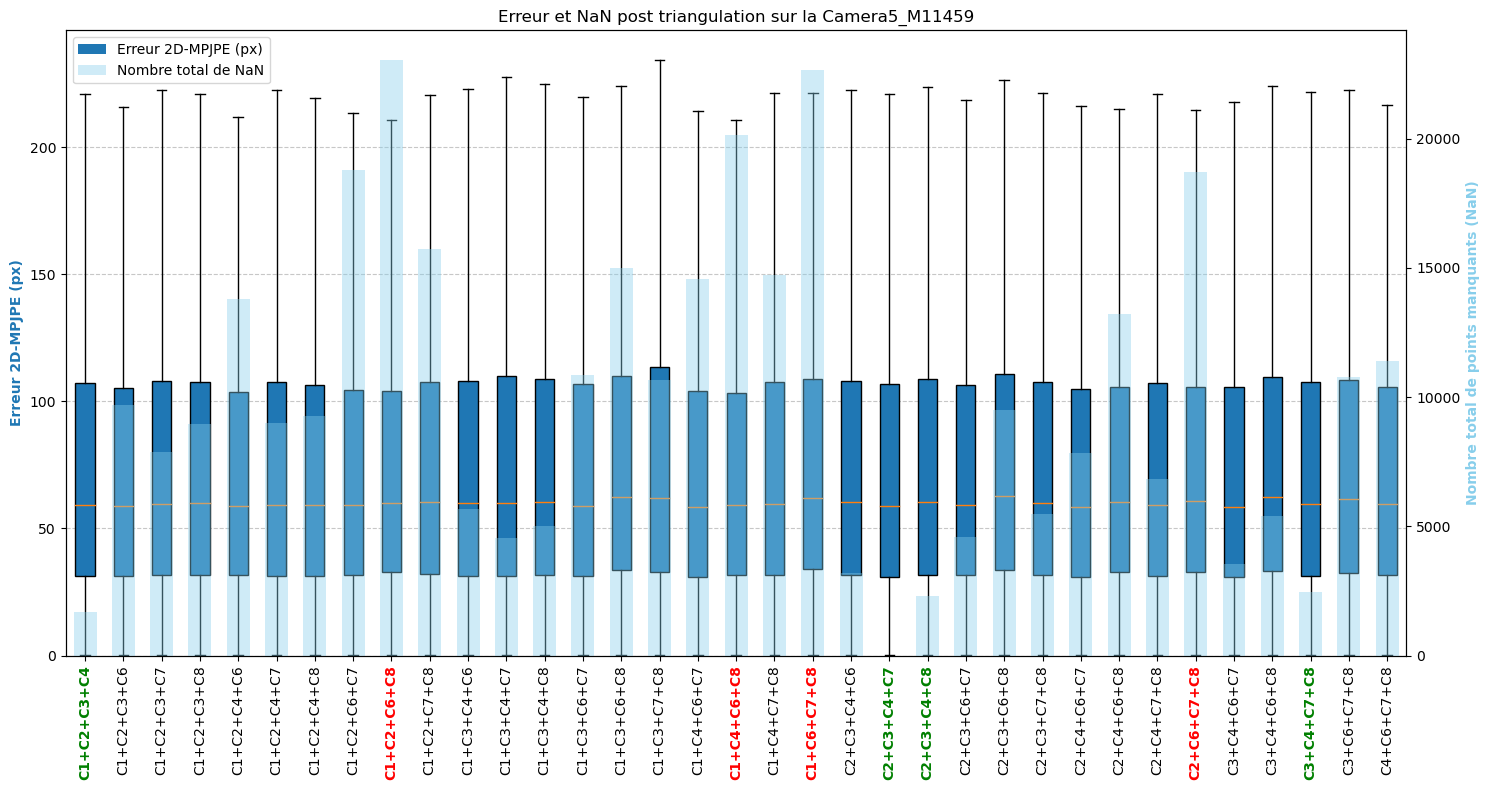

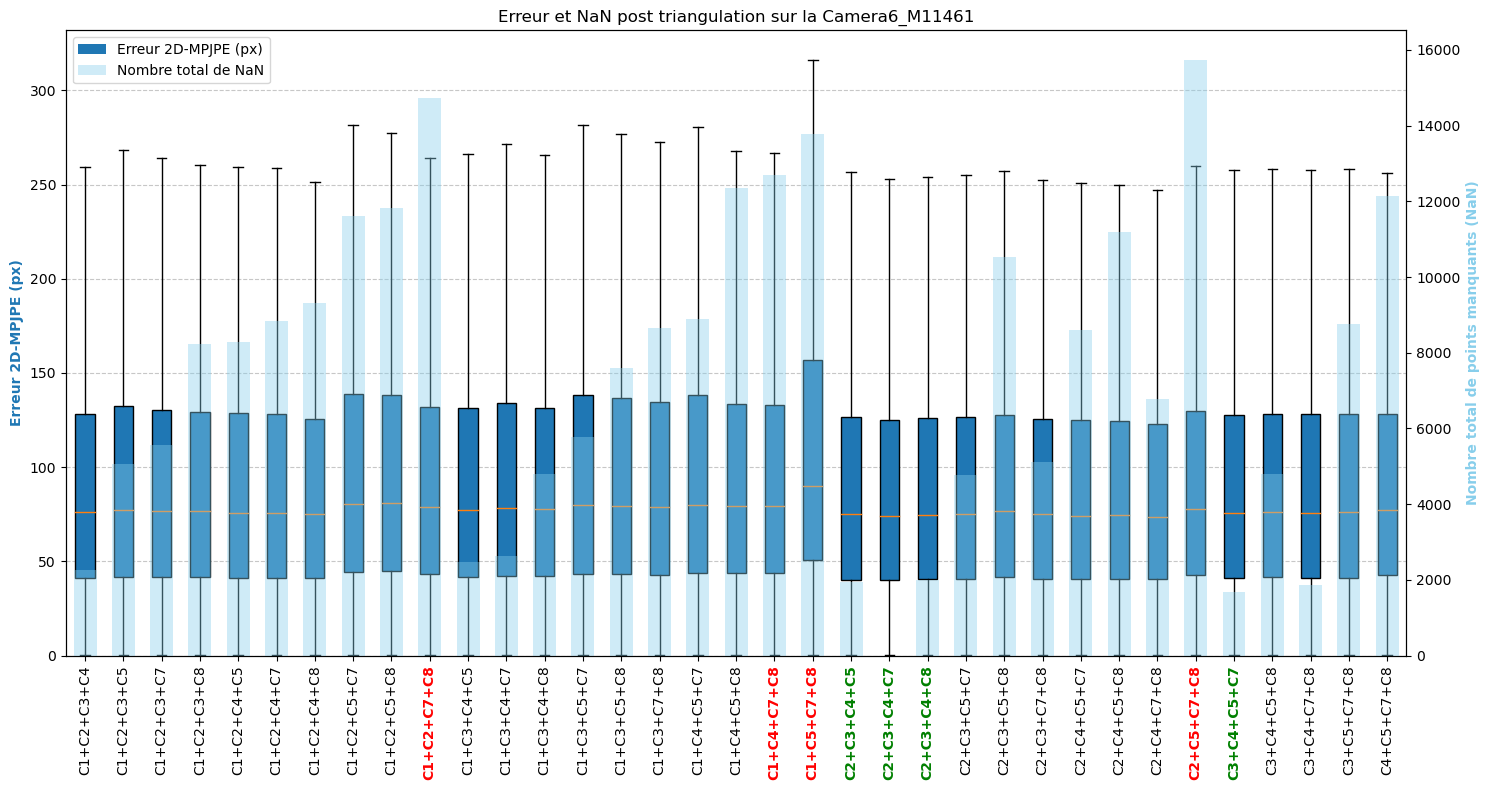

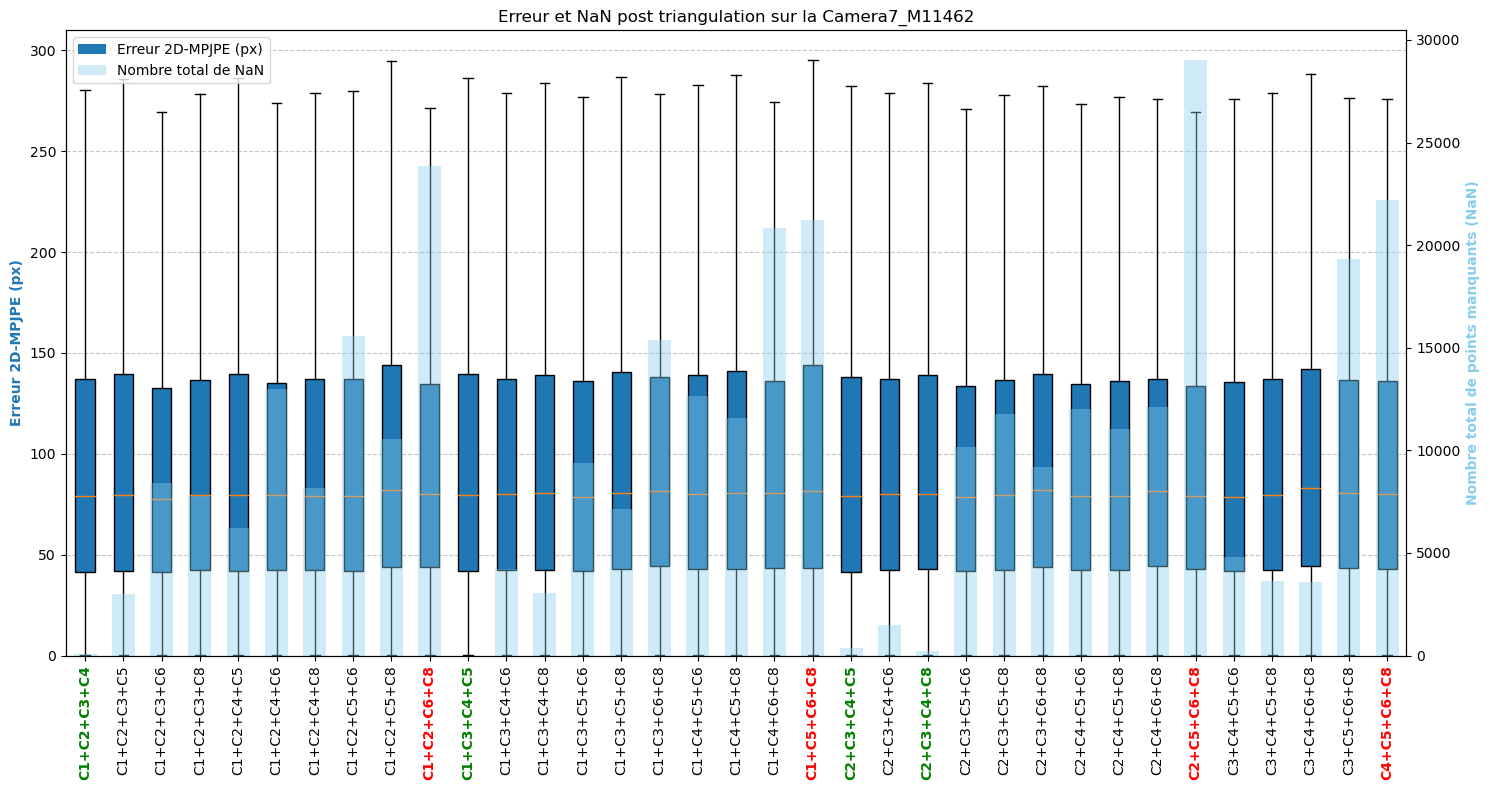

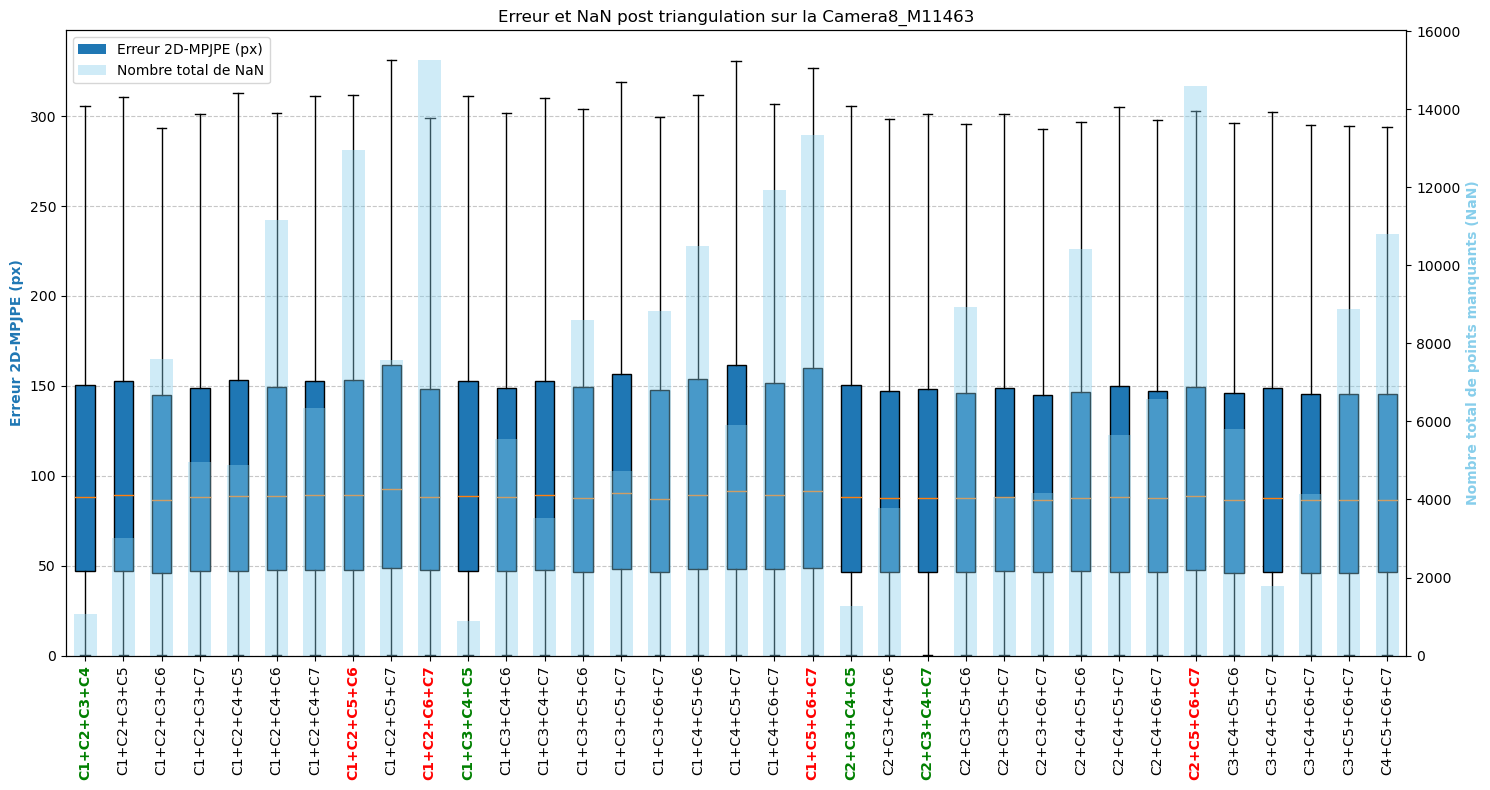

In [13]:
model = 'vit'

matching_2d = matching_vit
matching_3d = matching_pose2sim_vit

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141',
           'Camera4_M11458', 'Camera5_M11459', 'Camera6_M11461',
           'Camera7_M11462', 'Camera8_M11463']

dist_per_cam = get_MPJPE_per_cam(model, cameras, R, K, projMat, matching_2d, matching_3d)

plot_MPJPE_per_cam(dist_per_cam, model, showNaN=True)

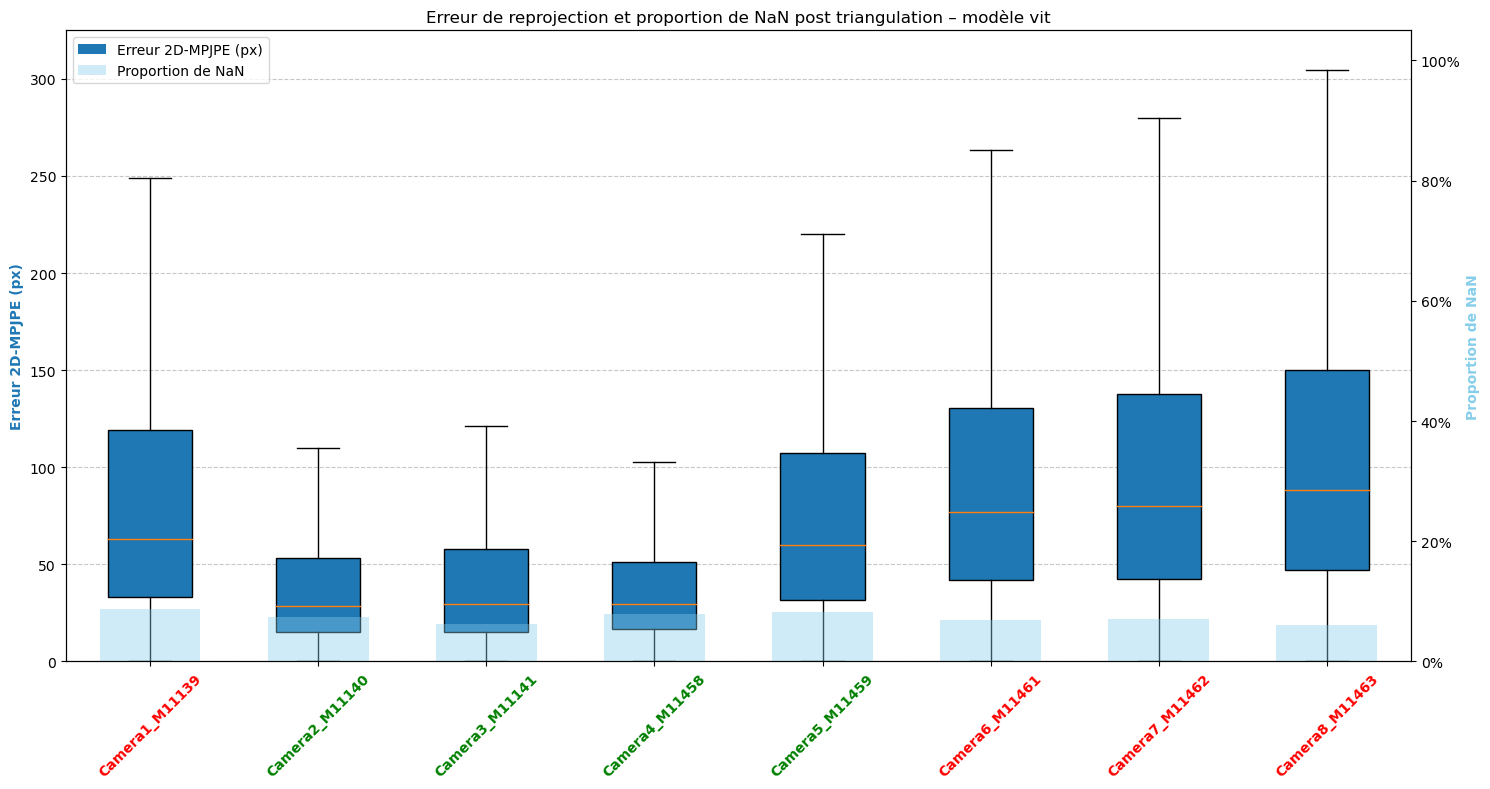

In [14]:
from data_analysis import plot_MPJPE_all_cams
plot_MPJPE_all_cams(dist_per_cam, model, showNaN=True, ylim=325)

In [15]:
get_all_error_stats(dist_per_cam)


--- Stats par combinaison ---
Camera1_M11139
  C2+C3+C4+C5: {'moyenne': 179.7874827734276, 'médiane': 63.41181780881922, 'écart_type': 303.2615540011873, 'q1': 32.76286152580815, 'q3': 124.09986906246539, 'max': 21517.77563637004}
  C2+C3+C4+C6: {'moyenne': 181.76679920594216, 'médiane': 64.36098496357076, 'écart_type': 472.3106998446331, 'q1': 33.55496609678985, 'q3': 122.88772042893346, 'max': 125910.47539349031}
  C2+C3+C4+C7: {'moyenne': 183.10270093996334, 'médiane': 62.91890325177475, 'écart_type': 529.8545525326917, 'q1': 32.49208545782788, 'q3': 122.67091792855581, 'max': 161904.02008448198}
  C2+C3+C4+C8: {'moyenne': 182.86009867236282, 'médiane': 64.12981685235087, 'écart_type': 508.73378846146016, 'q1': 33.512610244386295, 'q3': 124.63598420542687, 'max': 125910.47539349031}
  C2+C3+C5+C6: {'moyenne': 170.38545728195257, 'médiane': 62.63906808653828, 'écart_type': 283.41441939608, 'q1': 32.900604284420744, 'q3': 117.47580949112339, 'max': 3354.297269661176}
  C2+C3+C5+C7: {

### Filter detections based on CM to compute MPJPE between same person

In [16]:
model = 'vit'

matching_2d = matching_vit
matching_3d = matching_pose2sim_vit

cameras = ['Camera1_M11139', 'Camera2_M11140', 'Camera3_M11141',
           'Camera4_M11458', 'Camera5_M11459', 'Camera6_M11461',
           'Camera7_M11462', 'Camera8_M11463']

# define Rotation for Pose2Sim to World
R = np.array([[0, 0, 1],
              [-1, 0, 0],
              [0, 1, 0]])

dist_per_cam = get_MPJPE_per_cam_CoM(model, cameras, R, K, projMat, matching_2d, matching_3d, 150, 0.7)

#plot_MPJPE_per_cam(dist_per_cam, model, showNaN=True, ylim=200)
#get_all_error_stats(dist_per_cam)

--- C1 ---
--- C2 ---
--- C3 ---
--- C4 ---
--- C5 ---
--- C6 ---
--- C7 ---
--- C8 ---


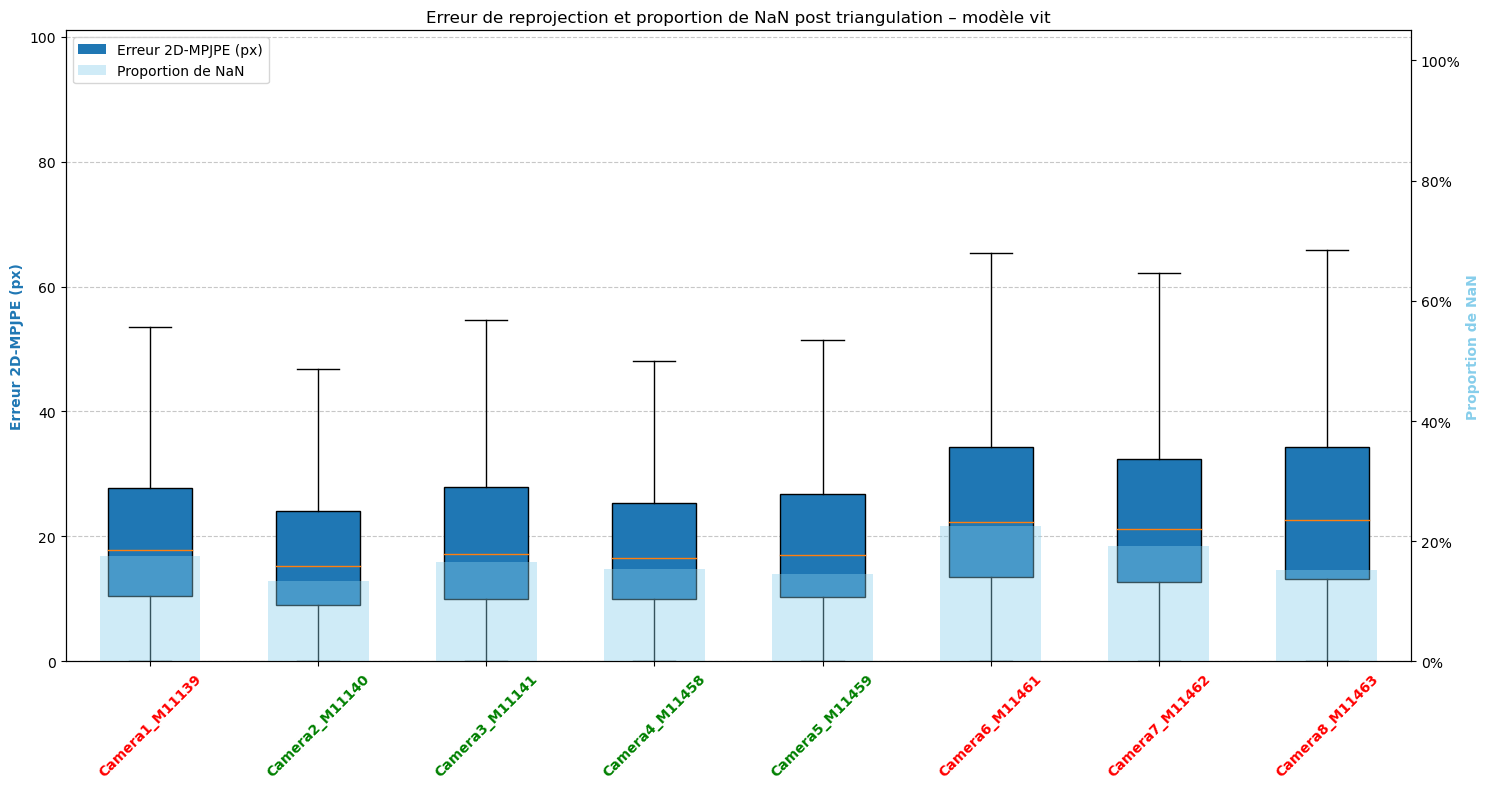

In [17]:
plot_MPJPE_all_cams(dist_per_cam, model, showNaN=True, ylim=101)

In [18]:
# Création d'un dictionnaire pour savoir quelles frames ont des détections
frames_with_detections = {}

for cam, cam_combs in dist_per_cam.items():
    frames_with_detections[cam] = {}
    for comb, dist_list in cam_combs.items():
        # dist_list est une liste, chaque élément correspond à un frame traité
        valid_frames = [i for i, d in enumerate(dist_list) if d is not None and len(d) > 0]
        frames_with_detections[cam][comb] = valid_frames

# Exemple d'affichage
for cam, cam_combs in frames_with_detections.items():
    print(f"\nCaméra {cam}:")
    for comb, frames in cam_combs.items():
        print(f"  Combinaison {comb}: {len(frames)} frames avec détections -> {frames}")



Caméra Camera1_M11139:
  Combinaison C2+C3+C4+C5: 573 frames avec détections -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205

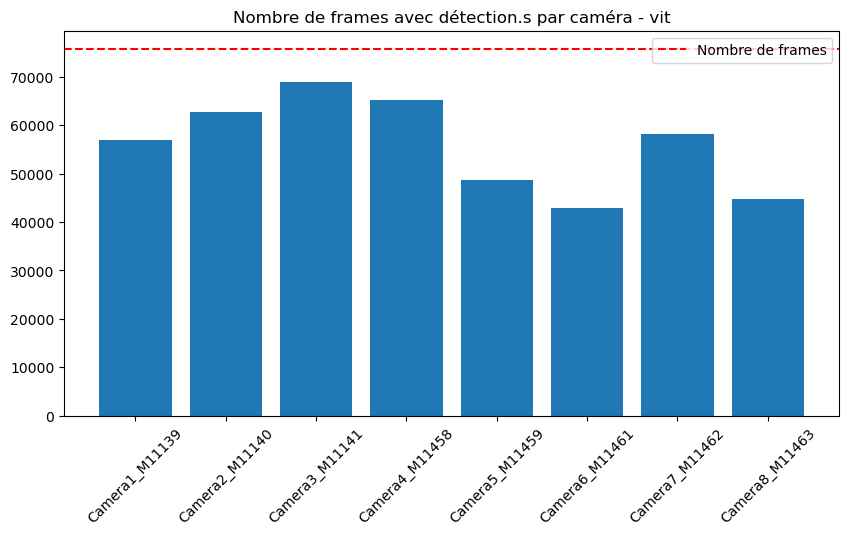

[56951. 62775. 68861. 65105. 48600. 42855. 58159. 44804.]
75754


In [19]:
from data_analysis import get_frame_name

def plot_heatmap_detections(frame_cam_dict, seq, threshold=4, plot=True):
    # Liste des caméras dans l'ordre
    cam_list = sorted(cameras)

    # Liste de tous les frames
    frame_list = sorted(frame_cam_dict.keys())

    # Matrice frame × cam (1 = détection, 0 = aucune détection)
    heatmap = np.zeros((len(cam_list), len(frame_list)), dtype=int)

    for i, cam in enumerate(cam_list):
        for j, f in enumerate(frame_list):
            if cam.strip() in [c.strip() for c in frame_cam_dict[f]]:
                heatmap[i, j] = 1

    N_detections = heatmap.sum(axis=0)

    if plot:
        # Affichage
        plt.figure(figsize=(15, 5))
        plt.imshow(heatmap, aspect='auto', cmap='Greens', origin='lower')

        plt.yticks(range(len(cam_list)), cam_list)
        plt.xticks(range(0, len(frame_list), max(1, len(frame_list)//10)), frame_list[::max(1, len(frame_list)//10)])
        plt.xlabel('Frames')
        plt.title(f'Frames avec (vert) ou sans (blanc) détection 2D par caméra - {seq}')

        for i, n in enumerate(N_detections):
            if n < threshold:
                plt.axvline(i, color='red', linewidth=0.8)

        plt.show()

    return heatmap

model = 'vit'
source_root = f'/home/lea/trampo/Pose2Sim/pose_all_{model}'
sequence_names = set(f.split('-')[0] for f in os.listdir(source_root))

frames_per_cam = {}  # dictionnaire: cam_name -> liste de frames détectés

f_max = 1920
heatmaps = np.zeros((8, f_max))
len_seq = np.zeros((1, f_max), dtype=int)
N_frames = 0

for seq in sorted(sequence_names):
    for cam_idx, cam_name in enumerate(cameras):
        frames_per_cam[cam_name] = set()

        folder_name = f"{seq}-{cam_name}_json"
        src_path = os.path.join(source_root, folder_name)
        
        # boucler sur les frames du dossier
        for frame_idx in range(0, len(os.listdir(src_path))):
            frame_name = get_frame_name(model, frame_idx)
            try:
                vit_pts, _ = load_2d_keypoints(f'{src_path}/{frame_name}.json')
            except FileNotFoundError:
                continue

            if vit_pts is not None:
                vit_pts = np.array(vit_pts)
                if vit_pts.size > 0:
                    frames_per_cam[cam_name].add(frame_idx)

    N_frames += len(os.listdir(src_path))
        
    frames_all = sorted(set().union(*frames_per_cam.values()))
    frame_cam_dict = {f: [] for f in frames_all}

    for f in frames_all:
        for cam, frames in frames_per_cam.items():
            if f in frames:
                frame_cam_dict[f].append(cam)

    heatmap = plot_heatmap_detections(frame_cam_dict, seq, 3, plot=False)
    heatmaps[:, 0:heatmap.shape[1]] += heatmap
    len_seq[:, :heatmap.shape[1]] += 1

cam_list = sorted(cameras)
""" # Affichage
heatmaps /= len_seq # normalize
heatmaps *= 100 # convert to %
plt.figure(figsize=(15, 5))
plt.imshow(heatmaps, aspect='auto', cmap='Greens', origin='lower')
plt.colorbar(label='% de détections')

frame_list = [i for i in range(heatmaps.shape[1])]
plt.yticks(range(len(cam_list)), cam_list)
plt.xticks(range(0, len(frame_list), max(1, len(frame_list)//10)), frame_list[::max(1, len(frame_list)//10)])
plt.xlabel('Frames')
plt.title(f'Détections par frames par caméra (normalisé) - Global')
plt.show() """

plt.figure(figsize=(10,5))
plt.bar(cam_list, heatmaps.sum(axis=1))
plt.xticks(rotation=45)
plt.axhline(N_frames, color='red', linestyle='--', label='Nombre de frames')
plt.title(f'Nombre de frames avec détection.s par caméra - {model}')
plt.ylim(0, N_frames*1.05)
plt.legend()
plt.show()

print(heatmaps.sum(axis=1))
print(N_frames)

In [26]:
det = [56951, 62775, 68861, 65105, 48600, 42855, 58159, 44804]
for d in det:
    print(f'{1-d/75754:.0%}') 


25%
17%
9%
14%
36%
43%
23%
41%


### Show detections and reprojections on images

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

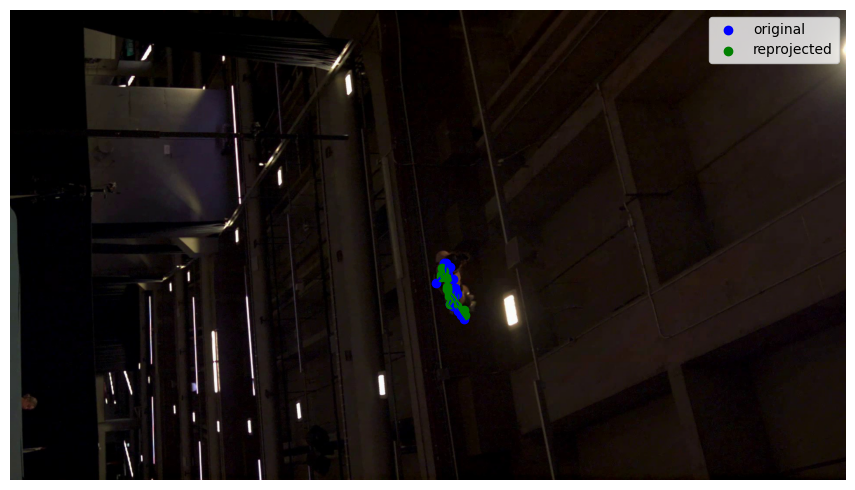

160 160


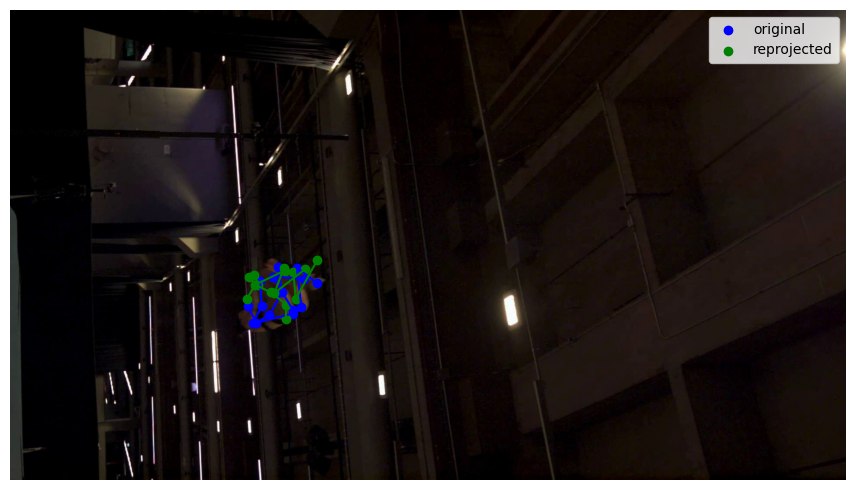

310 310


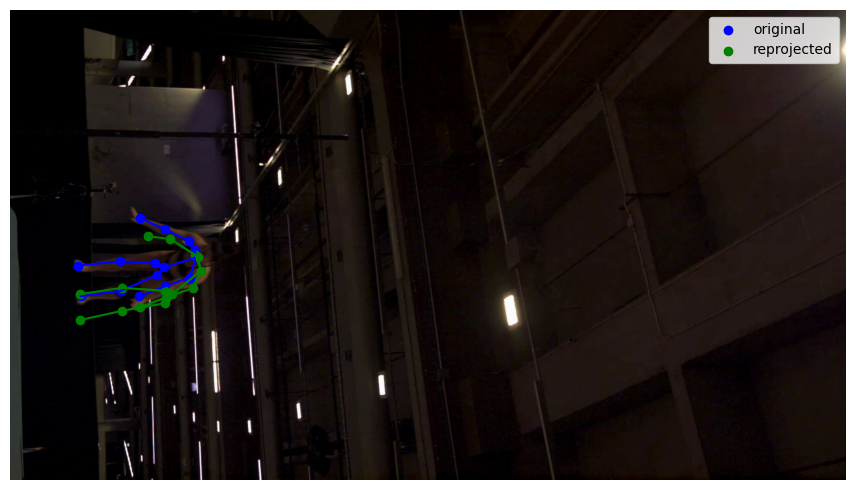

460 460


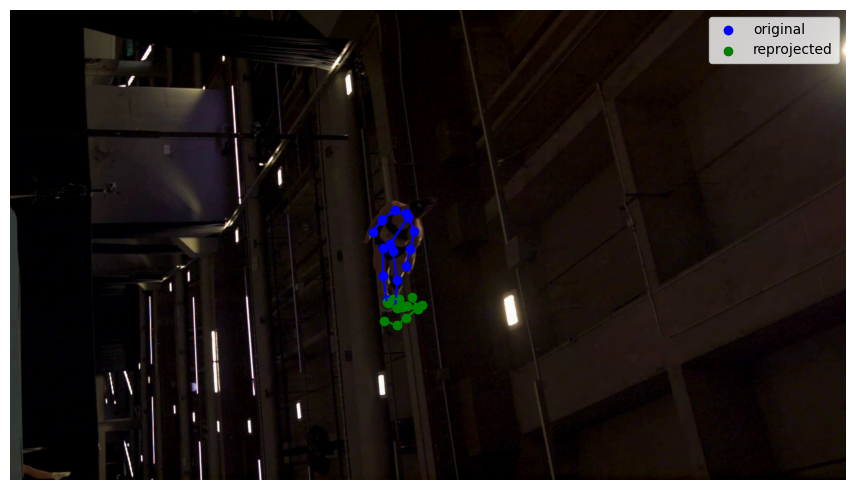

610 610


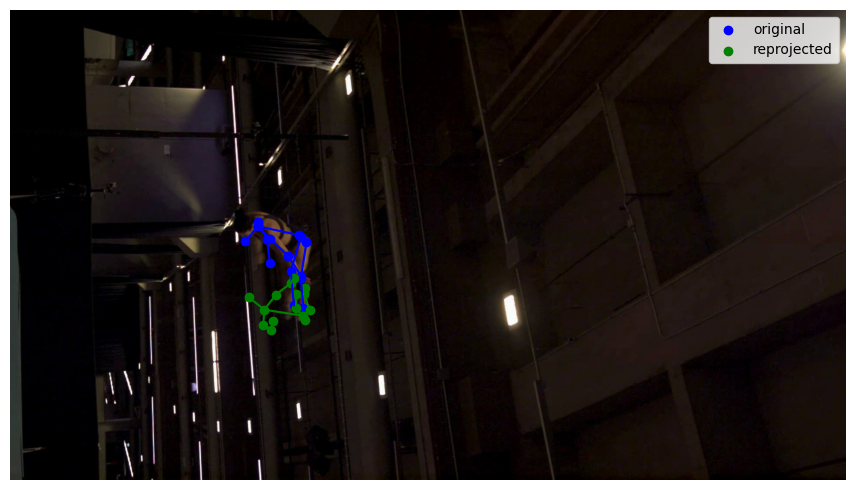

760 760


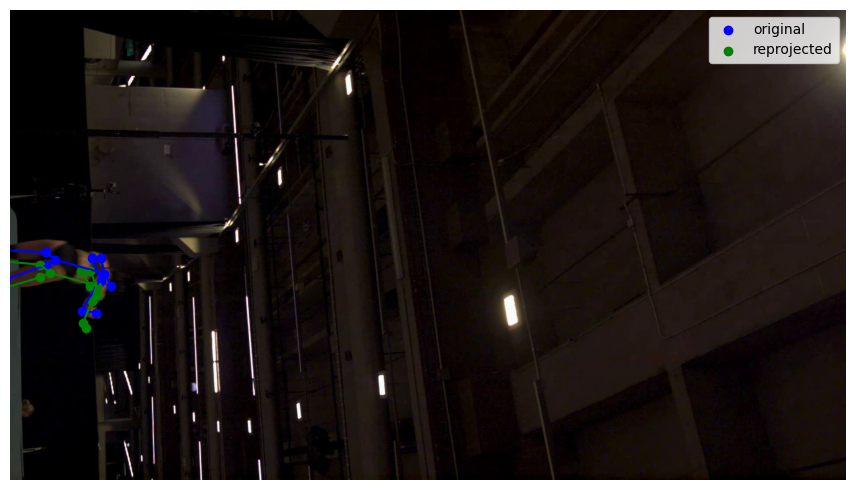

910 910


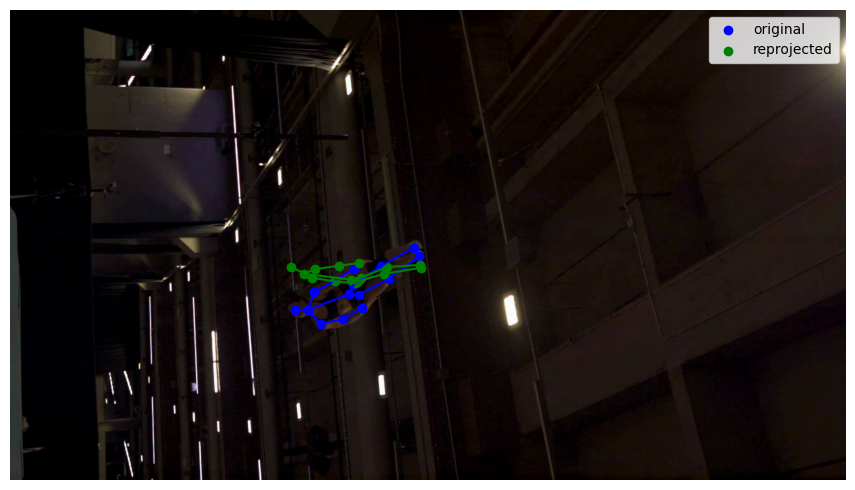

1060 1060


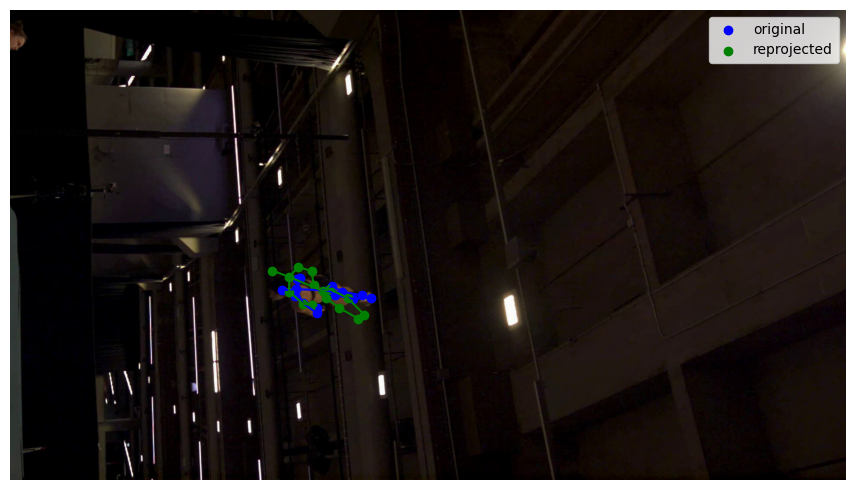

1210 1210


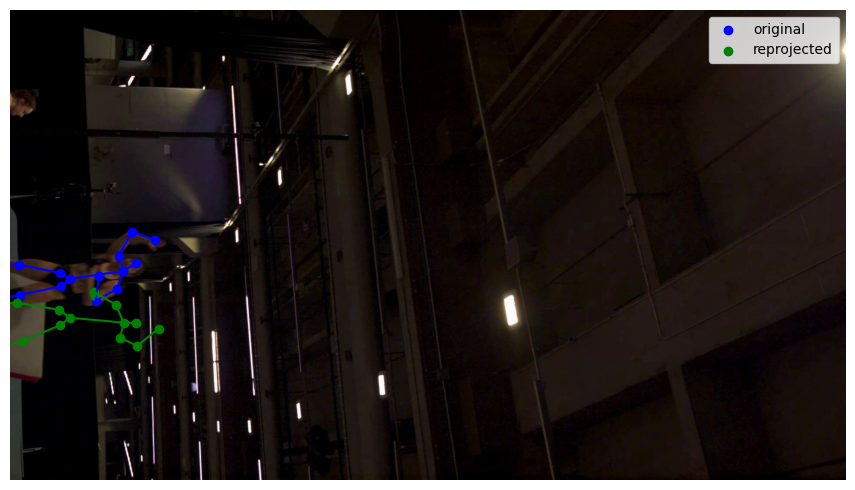

In [20]:
from compare_keypoints_3D import load_trc, extract_trc_positions, get_trc_frames
from multiview_consistency import computeP

plt.close()

routine = '1_partie_0429_002'
trc_path = f'/home/lea/trampo/Pose2Sim/pose-3d-4DHumans-multi/{routine}/C1+C2+C3+C4+C5+C6+C7/{routine}.trc'

trc_data, marker_names = load_trc(trc_path)
trc_positions = extract_trc_positions(trc_data, marker_names)

P_all, K_all = computeP('/home/lea/trampo/Pose2Sim/Calibration/Calib_all.toml')

cam_idx = 7
P = P_all[cam_idx]

pkl_path = f'/home/lea/trampo/Pose2Sim/pose_all_4dhumans/{routine}-{cameras[cam_idx]}_json' #Camera{cam_idx+1}

frames = get_trc_frames(trc_data, marker_names)
print(frames)

# define Rotation for Pose2Sim to World
R = np.array([[0, 0, 1],
              [-1, 0, 0],
              [0, 1, 0]])

for frame in frames[10::150]:
    pkl_file = os.path.join(pkl_path, f'frame_{frame:06d}.json')
    pkl_positions = load_2d_keypoints(pkl_file)
    try:
        pkl_2d = (np.array(pkl_positions[0]).T)[matching_humans]
        pkl_2d = pkl_2d.reshape((-1, 2))
    except IndexError:
        continue
    
    print(frame, frames.index(frame))
    points_3d = trc_positions[frames.index(frame)][matching_pose2sim]
    points_2d, mask = project_points_to_camera(points_3d*1000, K[cam_idx], projMat[cam_idx], R)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    img = mpimg.imread(f'/home/lea/trampo/4DHumans/outputs/_DEMO/{routine}-{cameras[cam_idx]}/img/{frame:06d}.jpg')
    ax.imshow(img)

    ax.scatter(*pkl_2d.T, color='blue', label='original')
    ax.scatter(*points_2d.T, color='green', label='reprojected')

    draw_skeleton(pkl_2d, 'blue', ax, '4dhumans')
    draw_skeleton(points_2d, 'green', ax, '4dhumans')

    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)
    ax.axis('off')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 3D visualization

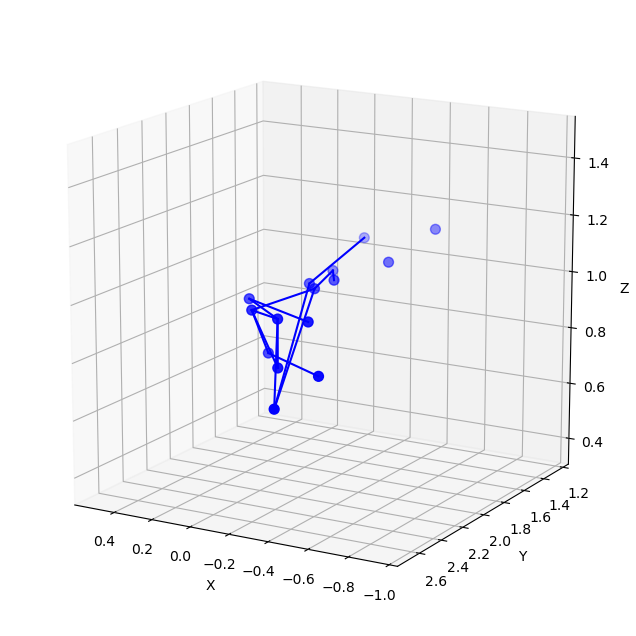

In [21]:
#%matplotlib widget
fig = plt.figure(figsize=(8, 8))

# Raw version
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(*points_3d.T, c='blue', s=50)
ax1.axis('equal')

draw_skeleton(points_3d, 'blue', ax1)

ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax1.set_box_aspect([1,1,1])
ax1.view_init(elev=15, azim=120)

plt.show()

(3, 13)


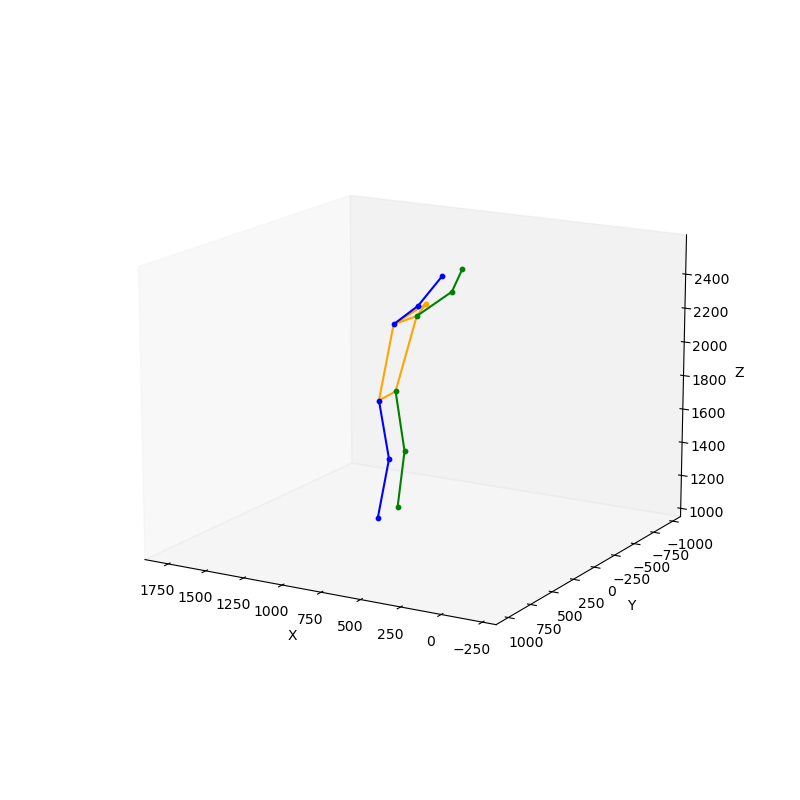

In [22]:
coords, frame_nb = extract_coordinates('/home/lea/trampo/Pose2Sim/pose-3d-vit-multi/1_partie_0429_000/GT_8cam/1_partie_0429_000.trc')

points_3d = coords[np.where(frame_nb==80)].squeeze()

points_3d = points_3d[matching_pose2sim_vit]
points_3d = R @ points_3d.T

print(points_3d.shape)

vit_pt_colors = ['orange', 'green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue']
vit_line_colors = ['orange', 'orange', 'orange', 'green', 'green', 'blue', 'blue', 'orange', 'orange', 'orange', 'green', 'green', 'blue', 'blue']

%matplotlib widget
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(111, projection='3d')
for i, (x, y, z) in enumerate(points_3d.T):
    ax1.scatter(x, y, z, c=vit_pt_colors[i], s=10)

draw_skeleton(points_3d.T, vit_line_colors, ax1, 'vit')

ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax1.view_init(elev=15, azim=120)
ax1.axis('equal')
ax1.grid(False)

plt.show()

In [23]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# --- Création de la figure 3D ---
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection='3d')

# Points
for i, (x, y, z) in enumerate(points_3d.T):
    ax1.scatter(x, y, z, c=vit_pt_colors[i], s=10)

# Squelette
draw_skeleton(points_3d.T, vit_line_colors, ax1, 'vit')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(elev=15, azim=120)
ax1.axis('equal')

# --- Fonction d’animation (fait tourner l’angle azimutal) ---
def update(frame):
    ax1.view_init(elev=-10 + frame/5, azim=120 + frame)  # rotation
    return fig,

# --- Animation ---
ani = FuncAnimation(fig, update, frames=180, interval=50, blit=False)

# Sauvegarde en GIF
ani.save("skeleton_rotation.gif", writer=PillowWriter(fps=10))

plt.close(fig)  # évite d'afficher une figure statique
